# Choosing the Language Model

This notebook contains the experiments on the language model selection.

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pickle
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pytorch_lightning as pl
import seaborn as sns
import torch
import umap
from pytorch_lightning import callbacks, seed_everything
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorboard.backend.event_processing import event_accumulator
from torch import nn

from nlp_assemblee.simple_datasets import AssembleeDataset
from nlp_assemblee.simple_precompute import plot_proj_from_emb_dict
from nlp_assemblee.simple_trainer import LitModel, load_embedding, process_predictions
from nlp_assemblee.simple_visualisation import (
    calculate_metrics,
    calculate_metrics_binary,
    plot_confusion_matrix,
    plot_network_graph,
    plot_precision_recall_curve,
    plot_precision_recall_curve_binary,
    plot_roc_curve,
    plot_roc_curve_binary,
)

seed_everything(42, workers=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Global seed set to 42


'cuda'

## Definition of the notebook variables

In [3]:
# To change between experiments
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

BATCH_SIZE = 512
MAX_EPOCHS = 100

OPTIMIZER_TYPE = "Adam"
OPTIMIZER_KWARGS = {"weight_decay": 1e-4}
LR = 5e-3
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "mode": "min",
    "factor": 0.1,
    "patience": 3,
    "interval": "epoch",
    "frequency": 1,
    "strict": True,
    "monitor": "val_loss",
}
# SCHEDULER_KWARGS = {
#     "scheduler": "OneCycleLR",
#     "max_lr": 5e-3,
#     "pct_start": 0.3,
#     "epochs": 30,
#     "steps_per_epoch": 100,
#     "interval": "epoch",
#     "frequency": 1,
#     "strict": True
# }


# Doesn't change between experiments
LABEL_VAR = "label"
DATA_ROOT = "../../data/"
NUM_WORKERS = 12
PREFETCH_FACTOR = 4
PIN_MEMORY = True
ACCELERATOR = "gpu"
DEVICE = "cuda"
LOG_EVERY_N_STEPS = 50
CHECK_VAL_EVERY_N_EPOCH = 1
DETERMINISTIC = False


### Definition of the net architecture
class Net(nn.Module):
    def __init__(self, root, embed_dim, inter_dim, n_classes=3, dropout=0.2, freeze=True):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, embed_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            }
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.freeze = freeze

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.intervention_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.mlp = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(inter_dim, inter_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(inter_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        contexte_repr = self.contexte_fc(contexte_emb)

        pooled_repr = intervention_repr + titre_repr + contexte_repr

        logits = self.mlp(pooled_repr)

        return logits

## CamemBERT base

### Experiment definition

In [5]:
MODEL_NAME = "camembert-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}/"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0.005,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, 768, 768, 3, dropout=0.2, freeze=True)

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0.005,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [6]:
trainer.fit(lit_model);

Missing logger folder: ../../results/lm_model_selection/camembert-base/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 3]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc.0       | Dropout

Output()

Metric val_loss improved. New best score: 0.869
Epoch 0, global step 356: 'val_loss' reached 0.86862 (best 0.86862), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=0-step=356.ckpt' as top 1


Metric val_loss improved by 0.013 >= min_delta = 0.005. New best score: 0.855
Epoch 1, global step 712: 'val_loss' reached 0.85535 (best 0.85535), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=1-step=712.ckpt' as top 1


Epoch 2, global step 1068: 'val_loss' was not in top 1


Metric val_loss improved by 0.018 >= min_delta = 0.005. New best score: 0.837
Epoch 3, global step 1424: 'val_loss' reached 0.83731 (best 0.83731), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=3-step=1424.ckpt' as top 1


Epoch 4, global step 1780: 'val_loss' was not in top 1


Epoch 5, global step 2136: 'val_loss' reached 0.83561 (best 0.83561), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=5-step=2136.ckpt' as top 1


Epoch 6, global step 2492: 'val_loss' was not in top 1


Epoch 7, global step 2848: 'val_loss' was not in top 1


Epoch 8, global step 3204: 'val_loss' was not in top 1


Epoch 9, global step 3560: 'val_loss' was not in top 1


Metric val_loss improved by 0.035 >= min_delta = 0.005. New best score: 0.803
Epoch 10, global step 3916: 'val_loss' reached 0.80276 (best 0.80276), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=10-step=3916.ckpt' as top 1


Epoch 11, global step 4272: 'val_loss' reached 0.79996 (best 0.79996), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=11-step=4272.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.797
Epoch 12, global step 4628: 'val_loss' reached 0.79726 (best 0.79726), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=12-step=4628.ckpt' as top 1


Epoch 13, global step 4984: 'val_loss' reached 0.79538 (best 0.79538), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=13-step=4984.ckpt' as top 1


Epoch 14, global step 5340: 'val_loss' reached 0.79418 (best 0.79418), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=14-step=5340.ckpt' as top 1


Epoch 15, global step 5696: 'val_loss' reached 0.79263 (best 0.79263), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=15-step=5696.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.790
Epoch 16, global step 6052: 'val_loss' reached 0.79026 (best 0.79026), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=16-step=6052.ckpt' as top 1


Epoch 17, global step 6408: 'val_loss' reached 0.78989 (best 0.78989), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=17-step=6408.ckpt' as top 1


Epoch 18, global step 6764: 'val_loss' reached 0.78938 (best 0.78938), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=18-step=6764.ckpt' as top 1


Epoch 19, global step 7120: 'val_loss' reached 0.78830 (best 0.78830), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=19-step=7120.ckpt' as top 1


Epoch 20, global step 7476: 'val_loss' reached 0.78596 (best 0.78596), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=20-step=7476.ckpt' as top 1


Epoch 21, global step 7832: 'val_loss' was not in top 1


Epoch 22, global step 8188: 'val_loss' reached 0.78584 (best 0.78584), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=22-step=8188.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.783
Epoch 23, global step 8544: 'val_loss' reached 0.78300 (best 0.78300), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=23-step=8544.ckpt' as top 1


Epoch 24, global step 8900: 'val_loss' reached 0.78253 (best 0.78253), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=24-step=8900.ckpt' as top 1


Epoch 25, global step 9256: 'val_loss' reached 0.78217 (best 0.78217), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=25-step=9256.ckpt' as top 1


Epoch 26, global step 9612: 'val_loss' was not in top 1


Epoch 27, global step 9968: 'val_loss' reached 0.78016 (best 0.78016), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=27-step=9968.ckpt' as top 1


Epoch 28, global step 10324: 'val_loss' was not in top 1


Epoch 29, global step 10680: 'val_loss' was not in top 1


Epoch 30, global step 11036: 'val_loss' reached 0.77947 (best 0.77947), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=30-step=11036.ckpt' as top 1


Epoch 31, global step 11392: 'val_loss' was not in top 1


Epoch 32, global step 11748: 'val_loss' reached 0.77885 (best 0.77885), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=32-step=11748.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.777
Epoch 33, global step 12104: 'val_loss' reached 0.77742 (best 0.77742), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=33-step=12104.ckpt' as top 1


Epoch 34, global step 12460: 'val_loss' reached 0.77702 (best 0.77702), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=34-step=12460.ckpt' as top 1


Epoch 35, global step 12816: 'val_loss' reached 0.77696 (best 0.77696), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=35-step=12816.ckpt' as top 1


Epoch 36, global step 13172: 'val_loss' reached 0.77588 (best 0.77588), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=36-step=13172.ckpt' as top 1


Epoch 37, global step 13528: 'val_loss' reached 0.77475 (best 0.77475), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=37-step=13528.ckpt' as top 1


Epoch 38, global step 13884: 'val_loss' was not in top 1


Epoch 39, global step 14240: 'val_loss' was not in top 1


Epoch 40, global step 14596: 'val_loss' reached 0.77469 (best 0.77469), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=40-step=14596.ckpt' as top 1


Epoch 41, global step 14952: 'val_loss' reached 0.77327 (best 0.77327), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=41-step=14952.ckpt' as top 1


Epoch 42, global step 15308: 'val_loss' reached 0.77304 (best 0.77304), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=42-step=15308.ckpt' as top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.777. Signaling Trainer to stop.
Epoch 43, global step 15664: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at ../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=42-step=15308.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=42-step=15308.ckpt


Output()

Metrics:  {'log_loss': 0.7694378406402423, 'accuracy': 0.6478656300425407, 'balanced_accuracy': 0.5265594872773125, 'recall_weighted': 0.6478656300425407, 'recall_micro': 0.6478656300425407, 'recall_macro': 0.5265594872773125, 'precision_weighted': 0.6448711079944232, 'precision_micro': 0.6478656300425407, 'precision_macro': 0.6400811446545781, 'f1_score_weighted': 0.6220240730153113, 'f1_score_micro': 0.6478656300425407, 'f1_score_macro': 0.5313956388540538, 'AUC_weighted_ovr': 0.792878313637955, 'AUC_macro_ovr': 0.7926840114900638, 'AUC_weighted_ovo': 0.7863126376094416, 'AUC_macro_ovo': 0.7836370582311721, 'jaccard_weighted': 0.4677177327927956, 'jaccard_micro': 0.4791429346352048, 'jaccard_macro': 0.3878327193773103, 'matthews_weighted': 0.3830535211948647, 'hamming_loss': 0.3521343699574593, 'confusion_matrix': [[43562, 801, 10182], [8946, 2262, 4085], [13859, 535, 24840]], 'confusion_matrix_true_normed': [[0.7986433220276835, 0.0146851223760198, 0.18667155559629664], [0.584973517

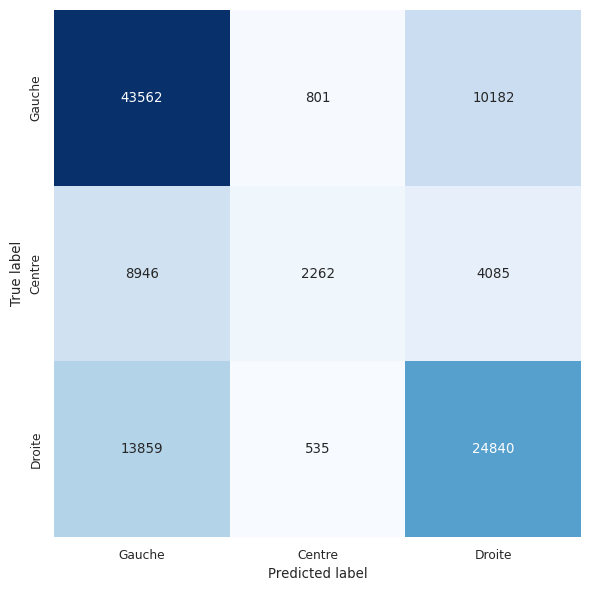

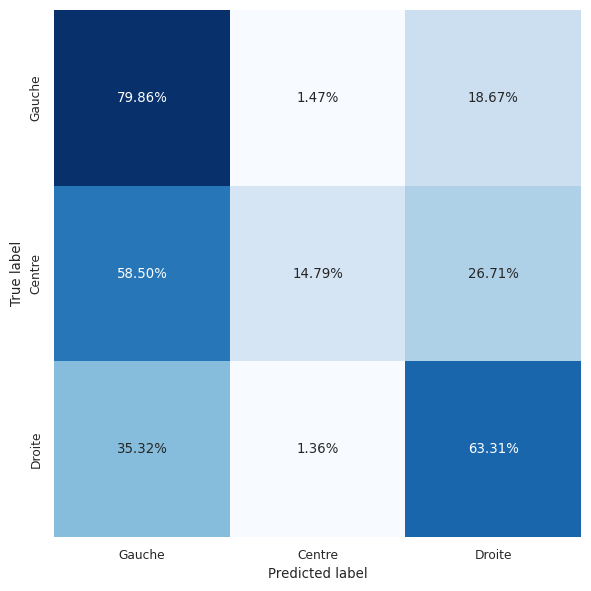

Micro-averaged One-vs-Rest ROC AUC score:
0.83
Macro-averaged One-vs-Rest ROC AUC score:
0.79


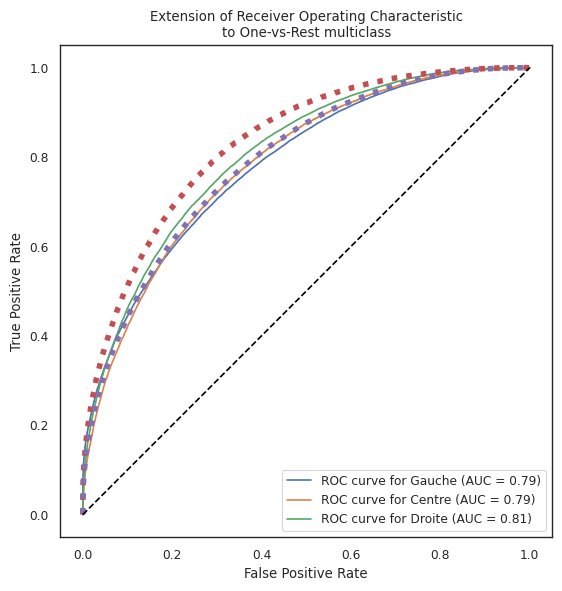

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


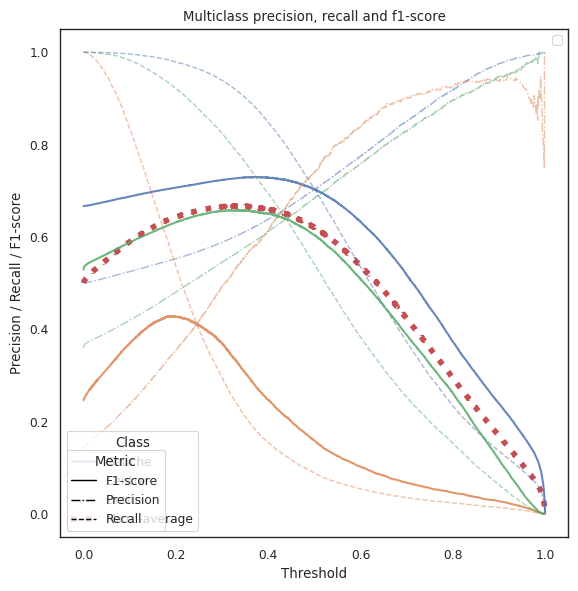

In [7]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## CamemBERT base binary

### Experiment definition

In [8]:
MODEL_NAME = "camembert-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}_binary"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
DROP_CENTER = True

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0.005,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, 768, 768, 2, dropout=0.2, freeze=True)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [9]:
trainer.fit(lit_model)

Missing logger folder: ../../results/lm_model_selection/camembert-base_binary/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc.0       | 

Output()

Metric val_loss improved. New best score: 0.573
Epoch 0, global step 306: 'val_loss' reached 0.57349 (best 0.57349), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_binary/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.568
Epoch 1, global step 612: 'val_loss' reached 0.56754 (best 0.56754), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_binary/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.562
Epoch 2, global step 918: 'val_loss' reached 0.56187 (best 0.56187), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_binary/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.005. New best score: 0.554
Epoch 3, global step 1224: 'val_loss' reached 0.55393 (best 0.55393), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_binary/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Epoch 4, global step 1530: 'val_loss' was not in top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.548
Epoch 5, global step 1836: 'val_loss' reached 0.54841 (best 0.54841), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_binary/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Epoch 6, global step 2142: 'val_loss' was not in top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.543
Epoch 7, global step 2448: 'val_loss' reached 0.54288 (best 0.54288), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_binary/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Epoch 8, global step 2754: 'val_loss' reached 0.54111 (best 0.54111), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_binary/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Epoch 9, global step 3060: 'val_loss' was not in top 1


Epoch 10, global step 3366: 'val_loss' was not in top 1


Epoch 11, global step 3672: 'val_loss' was not in top 1


Epoch 12, global step 3978: 'val_loss' reached 0.53816 (best 0.53816), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_binary/lightning_logs/epoch=12-step=3978.ckpt' as top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' was not in top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.543. Signaling Trainer to stop.
Epoch 17, global step 5508: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_binary/lightning_logs/epoch=12-step=3978.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_binary/lightning_logs/epoch=12-step=3978.ckpt


Output()

Metrics:  {'log_loss': 0.5372973628401242, 'accuracy': 0.7178152891372269, 'balanced_accuracy': 0.7019221613936213, 'recall': 0.6045776622317378, 'precision': 0.6841847183362658, 'f1_score': 0.6419225200600788, 'AUC': 0.7904588865873046, 'jaccard_weighted': 0.47267002769862304, 'matthews_weighted': 0.4126877823478799, 'hamming_loss': 0.28218471086277314, 'confusion_matrix': [[43596, 10949], [15514, 23720]], 'confusion_matrix_true_normed': [[0.7992666605555047, 0.20073333944449537], [0.39542233776826224, 0.6045776622317378]], 'confusion_matrix_pred_normed': [[0.737540179326679, 0.3158152816637342], [0.2624598206733209, 0.6841847183362658]], 'confusion_matrix_all_normed': [[0.46488019705904304, 0.11675321767133366], [0.16543149319143946, 0.2529350920781838]]}


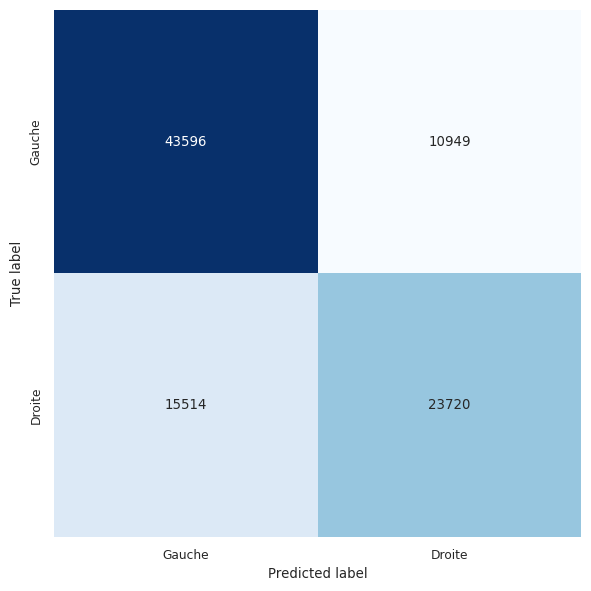

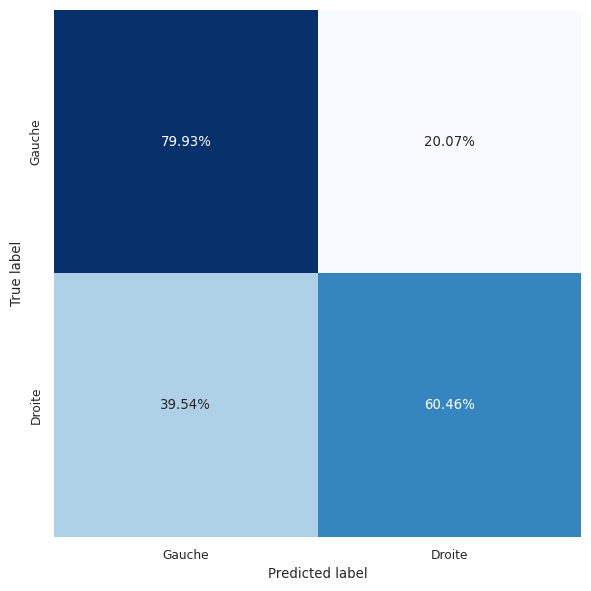

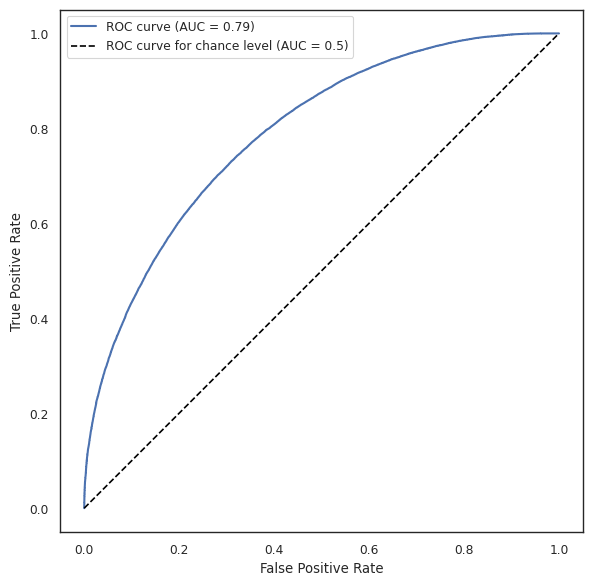

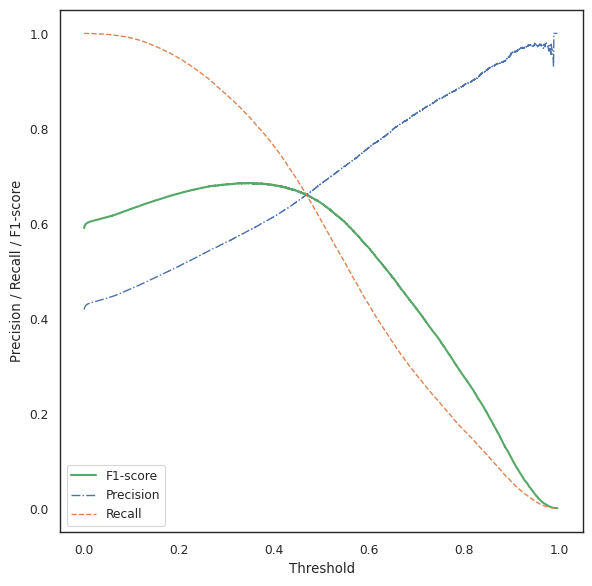

In [10]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## paraphrase-multilingual-MiniLM-L12-v2

### Experiment definition

In [11]:
MODEL_NAME = "paraphrase-multilingual-MiniLM-L12-v2"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
INPUT_DIM = 384
HIDDEN_DIM = 768

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0.005,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    embed_dim=INPUT_DIM,
    inter_dim=HIDDEN_DIM,
    n_classes=NUM_CLASSES,
    dropout=0.2,
    freeze=True,
)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [12]:
trainer.fit(lit_model)

Missing logger folder: ../../results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 3.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 2.0 M  | [32]      | [32, 384]
2  | classifier.titre_fc            | Sequential | 295 K  | [32, 384] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 384] | [32, 384]
4  | classifier.titre_fc.1          | Linear     | 295 K  | [32, 384] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 181 K  | [32]      | [32, 384]
7  | classifier.contexte_fc         | Sequential | 295 K  | [32, 384] | [32, 768]
8  | classifier.contex

Output()

Metric val_loss improved. New best score: 0.597
Epoch 0, global step 306: 'val_loss' reached 0.59687 (best 0.59687), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.013 >= min_delta = 0.005. New best score: 0.584
Epoch 1, global step 612: 'val_loss' reached 0.58362 (best 0.58362), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=1-step=612.ckpt' as top 1


Epoch 2, global step 918: 'val_loss' reached 0.58237 (best 0.58237), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.009 >= min_delta = 0.005. New best score: 0.575
Epoch 3, global step 1224: 'val_loss' reached 0.57506 (best 0.57506), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Epoch 4, global step 1530: 'val_loss' reached 0.57383 (best 0.57383), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.569
Epoch 5, global step 1836: 'val_loss' reached 0.56906 (best 0.56906), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Epoch 6, global step 2142: 'val_loss' was not in top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Epoch 8, global step 2754: 'val_loss' reached 0.56565 (best 0.56565), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Epoch 9, global step 3060: 'val_loss' was not in top 1


Epoch 10, global step 3366: 'val_loss' reached 0.56541 (best 0.56541), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 0.564
Epoch 11, global step 3672: 'val_loss' reached 0.56385 (best 0.56385), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' reached 0.56382 (best 0.56382), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Epoch 16, global step 5202: 'val_loss' reached 0.56233 (best 0.56233), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=16-step=5202.ckpt' as top 1


Epoch 17, global step 5508: 'val_loss' reached 0.56165 (best 0.56165), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=17-step=5508.ckpt' as top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.564. Signaling Trainer to stop.
Epoch 21, global step 6732: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=17-step=5508.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-MiniLM-L12-v2/lightning_logs/epoch=17-step=5508.ckpt


Output()

Metrics:  {'log_loss': 0.5592984369339344, 'accuracy': 0.7019055438850915, 'balanced_accuracy': 0.6840348922118913, 'recall': 0.574578171993679, 'precision': 0.6668145650309107, 'f1_score': 0.6172697526047015, 'AUC': 0.7694827462545383, 'jaccard_weighted': 0.446413719355222, 'matthews_weighted': 0.3781476020708844, 'hamming_loss': 0.2980944561149085, 'confusion_matrix': [[43281, 11264], [16691, 22543]], 'confusion_matrix_true_normed': [[0.7934916124301036, 0.20650838756989642], [0.42542182800632106, 0.574578171993679]], 'confusion_matrix_pred_normed': [[0.7216867871673448, 0.33318543496908926], [0.27831321283265525, 0.6668145650309107]], 'confusion_matrix_all_normed': [[0.4615212360976338, 0.12011217863274294], [0.17798227748216552, 0.24038430778745776]]}


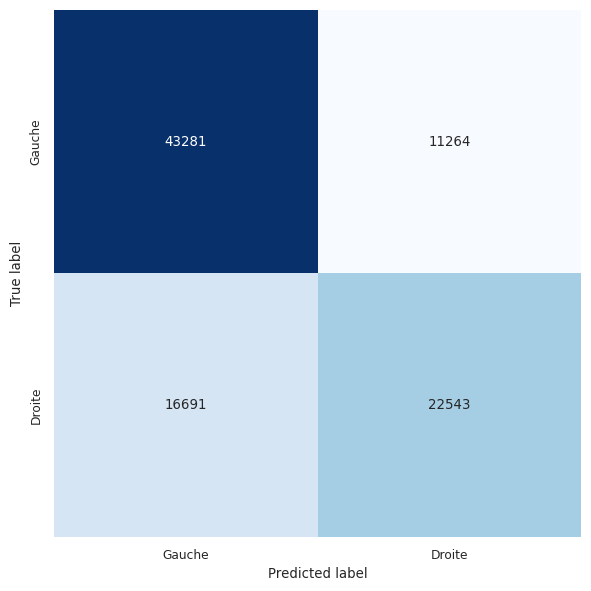

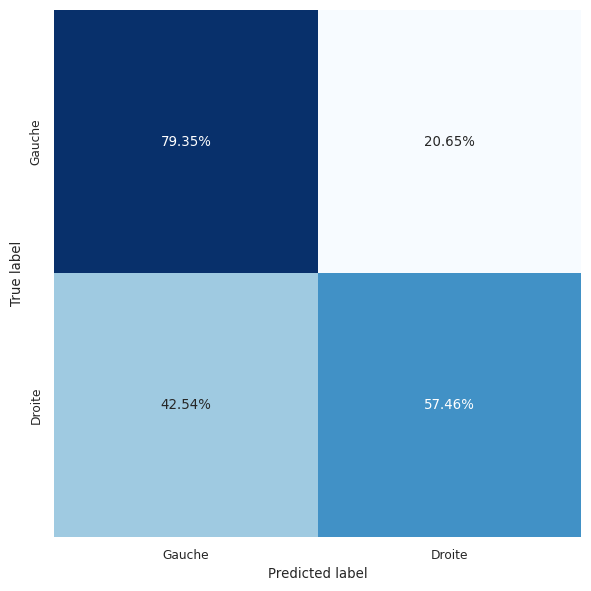

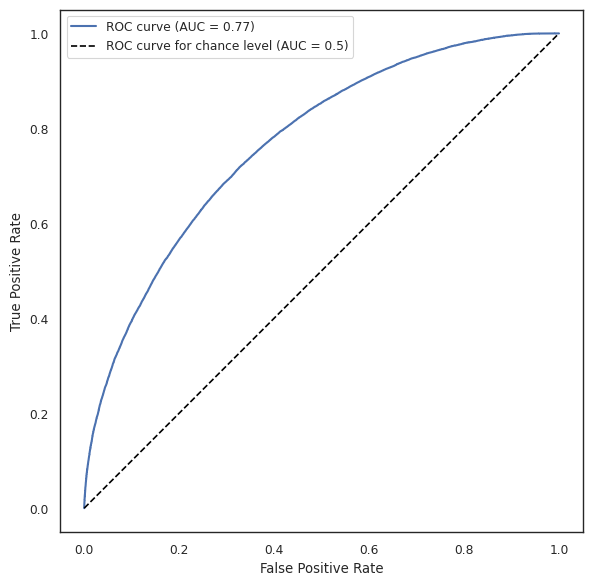

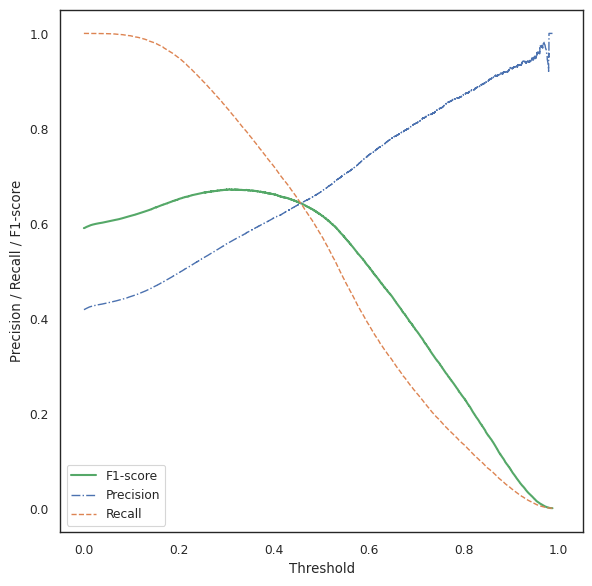

In [13]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## xlm-roberta-base

### Experiment definition

In [6]:
MODEL_NAME = "xlm-roberta-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
INPUT_DIM = 768
HIDDEN_DIM = 768

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0.005,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    embed_dim=INPUT_DIM,
    inter_dim=HIDDEN_DIM,
    n_classes=NUM_CLASSES,
    dropout=0.2,
    freeze=True,
)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [7]:
trainer.fit(lit_model);

Missing logger folder: ../../results/lm_model_selection/xlm-roberta-base/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc.0       | Dropo

Output()

Metric val_loss improved. New best score: 0.601
Epoch 0, global step 306: 'val_loss' reached 0.60118 (best 0.60118), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=0-step=306.ckpt' as top 1


Epoch 1, global step 612: 'val_loss' was not in top 1


Metric val_loss improved by 0.012 >= min_delta = 0.005. New best score: 0.589
Epoch 2, global step 918: 'val_loss' reached 0.58897 (best 0.58897), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=2-step=918.ckpt' as top 1


Epoch 3, global step 1224: 'val_loss' reached 0.58485 (best 0.58485), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Epoch 4, global step 1530: 'val_loss' was not in top 1


Epoch 5, global step 1836: 'val_loss' was not in top 1


Epoch 6, global step 2142: 'val_loss' was not in top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Metric val_loss improved by 0.017 >= min_delta = 0.005. New best score: 0.572
Epoch 8, global step 2754: 'val_loss' reached 0.57209 (best 0.57209), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Epoch 9, global step 3060: 'val_loss' was not in top 1


Epoch 10, global step 3366: 'val_loss' reached 0.56951 (best 0.56951), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Epoch 11, global step 3672: 'val_loss' reached 0.56823 (best 0.56823), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.566
Epoch 13, global step 4284: 'val_loss' reached 0.56615 (best 0.56615), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=13-step=4284.ckpt' as top 1


Epoch 14, global step 4590: 'val_loss' reached 0.56608 (best 0.56608), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=14-step=4590.ckpt' as top 1


Epoch 15, global step 4896: 'val_loss' reached 0.56588 (best 0.56588), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Epoch 16, global step 5202: 'val_loss' reached 0.56518 (best 0.56518), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=16-step=5202.ckpt' as top 1


Epoch 17, global step 5508: 'val_loss' reached 0.56267 (best 0.56267), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=17-step=5508.ckpt' as top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' reached 0.56242 (best 0.56242), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=21-step=6732.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.559
Epoch 22, global step 7038: 'val_loss' reached 0.55928 (best 0.55928), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=22-step=7038.ckpt' as top 1


Epoch 23, global step 7344: 'val_loss' was not in top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Epoch 26, global step 8262: 'val_loss' was not in top 1


Epoch 27, global step 8568: 'val_loss' reached 0.55568 (best 0.55568), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=27-step=8568.ckpt' as top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Epoch 29, global step 9180: 'val_loss' was not in top 1


Epoch 30, global step 9486: 'val_loss' was not in top 1


Epoch 31, global step 9792: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.559. Signaling Trainer to stop.
Epoch 32, global step 10098: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=27-step=8568.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base/lightning_logs/epoch=27-step=8568.ckpt


Output()

Metrics:  {'log_loss': 0.5548499973214523, 'accuracy': 0.7091246441100886, 'balanced_accuracy': 0.6925159435418533, 'recall': 0.5907886017229954, 'precision': 0.6737689669205279, 'f1_score': 0.6295561953392363, 'AUC': 0.7770660995164373, 'jaccard_weighted': 0.45938125532631746, 'matthews_weighted': 0.39409823820689444, 'hamming_loss': 0.29087535588991137, 'confusion_matrix': [[43322, 11223], [16055, 23179]], 'confusion_matrix_true_normed': [[0.7942432853607113, 0.20575671463928866], [0.40921139827700465, 0.5907886017229954]], 'confusion_matrix_pred_normed': [[0.7296091079037338, 0.3262310330794721], [0.2703908920962662, 0.6737689669205279]], 'confusion_matrix_all_normed': [[0.46195843419102356, 0.11967498053935316], [0.17120037535055824, 0.24716620991906504]]}


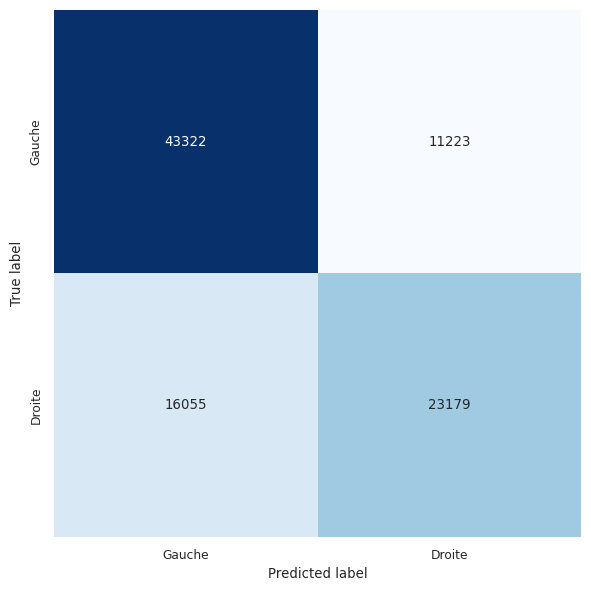

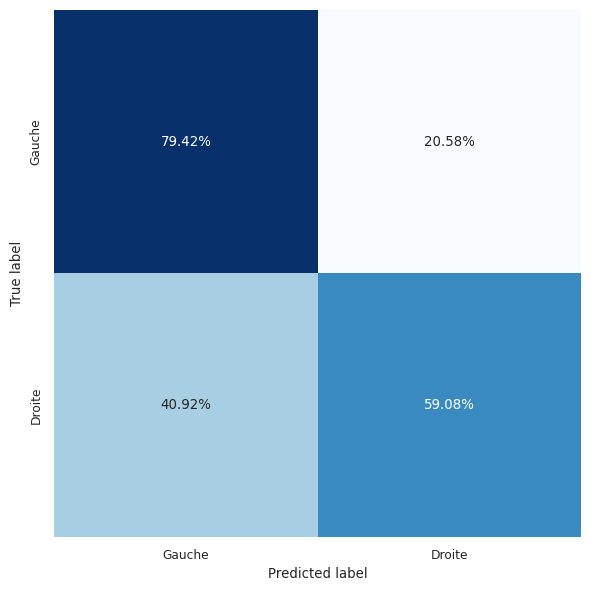

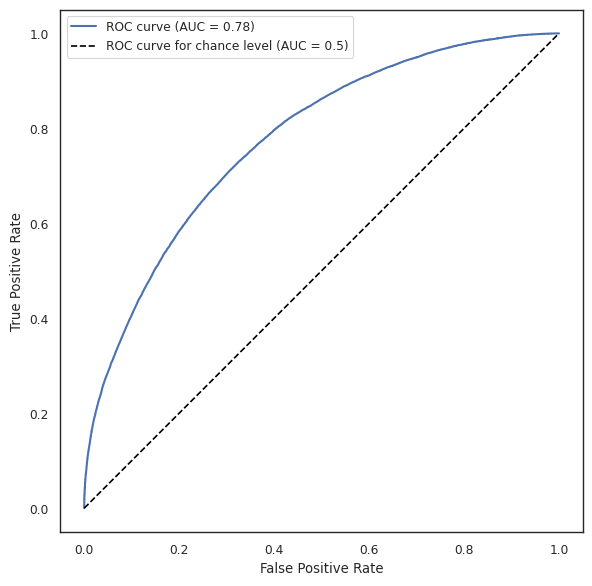

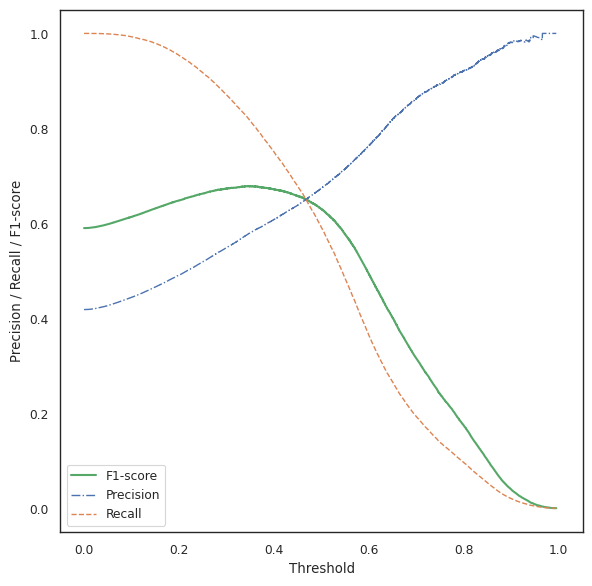

In [8]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## xlm-roberta-base unfrozen embeddings

### Experiment definition

In [9]:
MODEL_NAME = "xlm-roberta-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}_unfrozen"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
INPUT_DIM = 768
HIDDEN_DIM = 768

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0.005,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    embed_dim=INPUT_DIM,
    inter_dim=HIDDEN_DIM,
    n_classes=NUM_CLASSES,
    dropout=0.2,
    freeze=False,
)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [10]:
trainer.fit(lit_model);

Missing logger folder: ../../results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc.0     

Output()

Metric val_loss improved. New best score: 0.622
Epoch 0, global step 306: 'val_loss' reached 0.62163 (best 0.62163), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.031 >= min_delta = 0.005. New best score: 0.590
Epoch 1, global step 612: 'val_loss' reached 0.59040 (best 0.59040), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=1-step=612.ckpt' as top 1


Epoch 2, global step 918: 'val_loss' was not in top 1


Metric val_loss improved by 0.029 >= min_delta = 0.005. New best score: 0.561
Epoch 3, global step 1224: 'val_loss' reached 0.56124 (best 0.56124), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Epoch 4, global step 1530: 'val_loss' was not in top 1


Metric val_loss improved by 0.011 >= min_delta = 0.005. New best score: 0.550
Epoch 5, global step 1836: 'val_loss' reached 0.54997 (best 0.54997), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Epoch 6, global step 2142: 'val_loss' reached 0.54992 (best 0.54992), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Epoch 8, global step 2754: 'val_loss' was not in top 1


Epoch 9, global step 3060: 'val_loss' was not in top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.543
Epoch 10, global step 3366: 'val_loss' reached 0.54343 (best 0.54343), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Epoch 11, global step 3672: 'val_loss' was not in top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' reached 0.54099 (best 0.54099), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=13-step=4284.ckpt' as top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' reached 0.53920 (best 0.53920), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.536
Epoch 16, global step 5202: 'val_loss' reached 0.53612 (best 0.53612), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=16-step=5202.ckpt' as top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Epoch 22, global step 7038: 'val_loss' was not in top 1


Epoch 23, global step 7344: 'val_loss' was not in top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.536. Signaling Trainer to stop.
Epoch 26, global step 8262: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=16-step=5202.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_unfrozen/lightning_logs/epoch=16-step=5202.ckpt


Output()

Metrics:  {'log_loss': 0.5335263837624867, 'accuracy': 0.7201612301261476, 'balanced_accuracy': 0.6987911022901283, 'recall': 0.5679002905643065, 'precision': 0.7057426118906591, 'f1_score': 0.6293623331685615, 'AUC': 0.7962026139558708, 'jaccard_weighted': 0.4591748413156376, 'matthews_weighted': 0.41501941689854116, 'hamming_loss': 0.27983876987385237, 'confusion_matrix': [[45255, 9290], [16953, 22281]], 'confusion_matrix_true_normed': [[0.8296819140159502, 0.17031808598404988], [0.43209970943569354, 0.5679002905643065]], 'confusion_matrix_pred_normed': [[0.7274787808641975, 0.2942573881093409], [0.27252121913580246, 0.7057426118906591]], 'confusion_matrix_all_normed': [[0.4825707247891319, 0.09906268994124484], [0.18077607993260753, 0.23759050533701576]]}


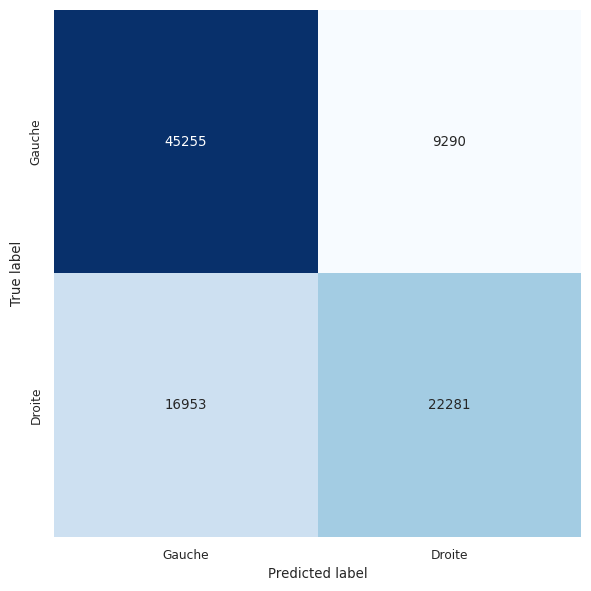

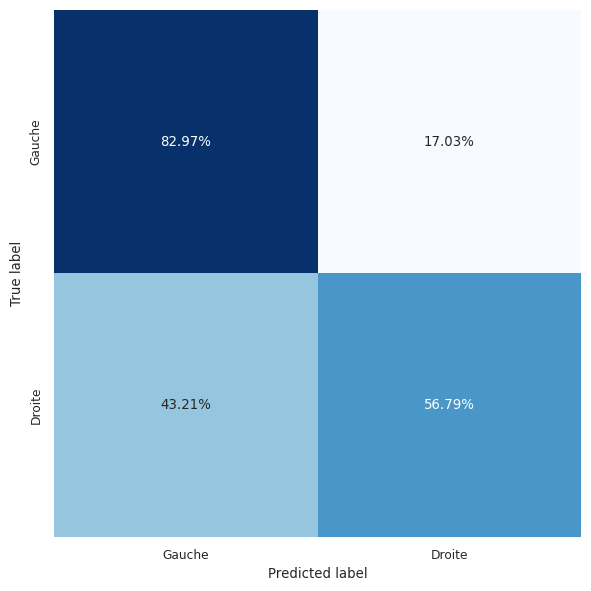

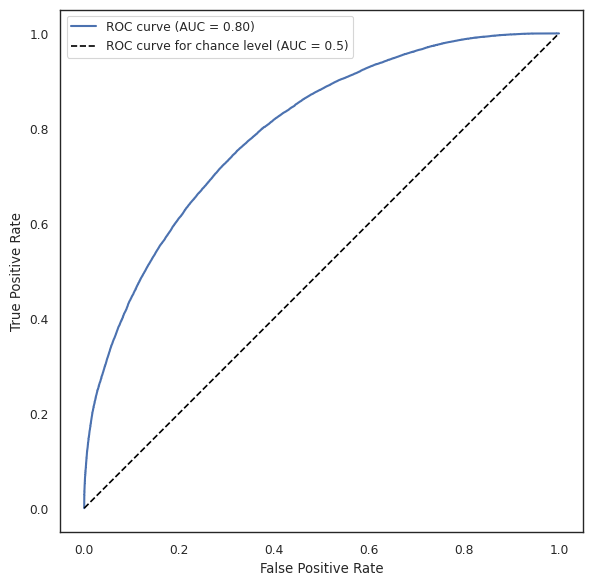

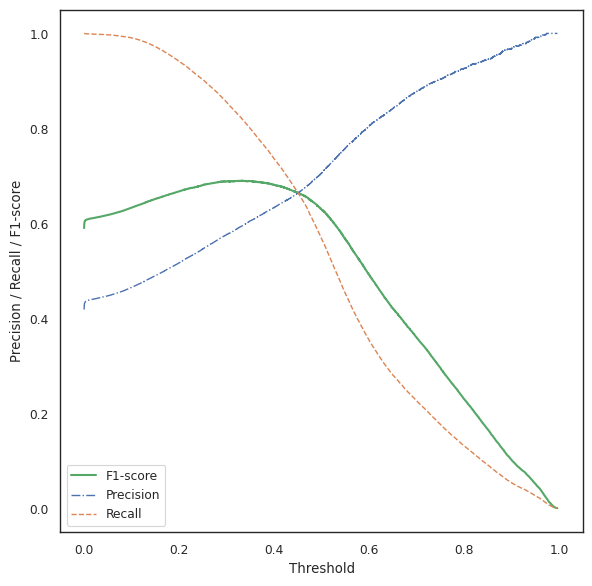

In [11]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## paraphrase-multilingual-mpnet-base-v2

### Experiment definition

In [14]:
MODEL_NAME = "paraphrase-multilingual-mpnet-base-v2"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
INPUT_DIM = 768
HIDDEN_DIM = 768


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0.005,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    embed_dim=INPUT_DIM,
    inter_dim=HIDDEN_DIM,
    n_classes=NUM_CLASSES,
    dropout=0.2,
    freeze=True,
)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [15]:
trainer.fit(lit_model);

Missing logger folder: ../../results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contex

Output()

Metric val_loss improved. New best score: 0.588
Epoch 0, global step 306: 'val_loss' reached 0.58835 (best 0.58835), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.582
Epoch 1, global step 612: 'val_loss' reached 0.58180 (best 0.58180), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.017 >= min_delta = 0.005. New best score: 0.565
Epoch 2, global step 918: 'val_loss' reached 0.56529 (best 0.56529), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs/epoch=2-step=918.ckpt' as top 1


Epoch 3, global step 1224: 'val_loss' was not in top 1


Epoch 4, global step 1530: 'val_loss' was not in top 1


Epoch 5, global step 1836: 'val_loss' reached 0.56387 (best 0.56387), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Epoch 6, global step 2142: 'val_loss' was not in top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.560
Epoch 7, global step 2448: 'val_loss' reached 0.55960 (best 0.55960), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Epoch 8, global step 2754: 'val_loss' reached 0.55651 (best 0.55651), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Epoch 9, global step 3060: 'val_loss' reached 0.55559 (best 0.55559), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Epoch 10, global step 3366: 'val_loss' was not in top 1


Epoch 11, global step 3672: 'val_loss' was not in top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' reached 0.55555 (best 0.55555), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.560. Signaling Trainer to stop.
Epoch 17, global step 5508: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs/epoch=15-step=4896.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/paraphrase-multilingual-mpnet-base-v2/lightning_logs/epoch=15-step=4896.ckpt


Output()

Metrics:  {'log_loss': 0.5532818383380911, 'accuracy': 0.7057550197805479, 'balanced_accuracy': 0.6792629533913428, 'recall': 0.5170005607381353, 'precision': 0.7011891592920354, 'f1_score': 0.5951703295091105, 'AUC': 0.7779311532409956, 'jaccard_weighted': 0.42366013617945614, 'matthews_weighted': 0.3829232769051428, 'hamming_loss': 0.2942449802194521, 'confusion_matrix': [[45901, 8644], [18950, 20284]], 'confusion_matrix_true_normed': [[0.8415253460445504, 0.15847465395544963], [0.4829994392618647, 0.5170005607381353]], 'confusion_matrix_pred_normed': [[0.7077917071440687, 0.2988108407079646], [0.2922082928559313, 0.7011891592920354]], 'confusion_matrix_all_normed': [[0.48945926060205375, 0.09217415412832297], [0.20207082609112914, 0.2162957591784941]]}


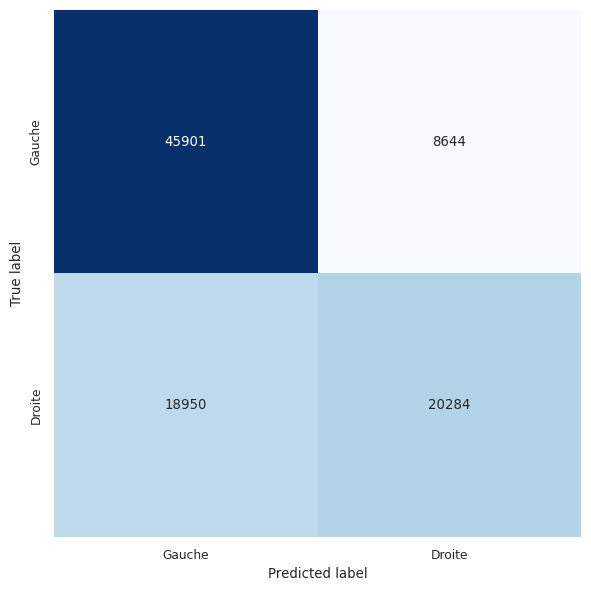

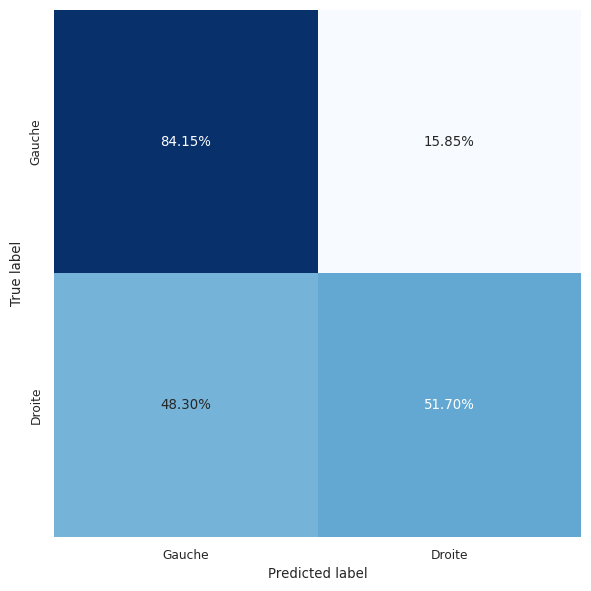

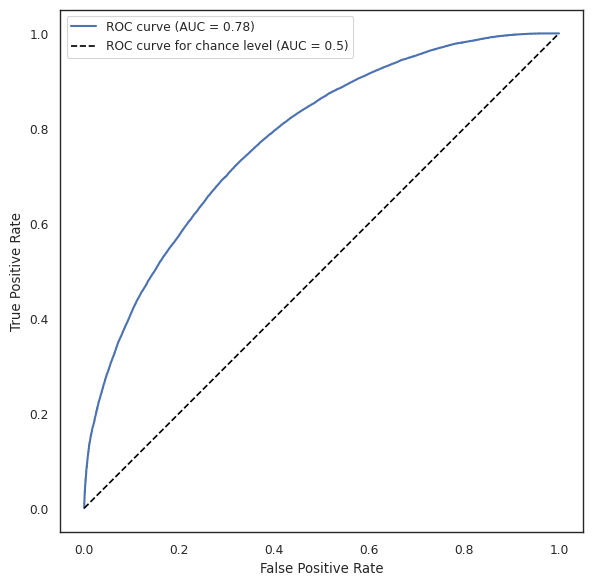

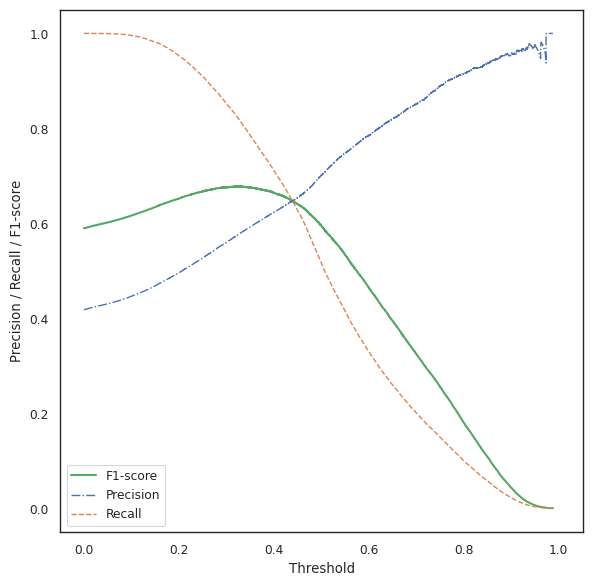

In [16]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## distiluse-base-multilingual-cased-v2

### Experiment definition

In [19]:
MODEL_NAME = "distiluse-base-multilingual-cased-v2"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
INPUT_DIM = 512
HIDDEN_DIM = 768


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0.005,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    embed_dim=INPUT_DIM,
    inter_dim=HIDDEN_DIM,
    n_classes=NUM_CLASSES,
    dropout=0.2,
    freeze=True,
)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [20]:
trainer.fit(lit_model);

Missing logger folder: ../../results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 4.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 2.6 M  | [32]      | [32, 512]
2  | classifier.titre_fc            | Sequential | 393 K  | [32, 512] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 512] | [32, 512]
4  | classifier.titre_fc.1          | Linear     | 393 K  | [32, 512] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 242 K  | [32]      | [32, 512]
7  | classifier.contexte_fc         | Sequential | 393 K  | [32, 512] | [32, 768]
8  | classifier.context

Output()

Metric val_loss improved. New best score: 0.605
Epoch 0, global step 306: 'val_loss' reached 0.60453 (best 0.60453), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 0.599
Epoch 1, global step 612: 'val_loss' reached 0.59925 (best 0.59925), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 0.589
Epoch 2, global step 918: 'val_loss' reached 0.58935 (best 0.58935), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.584
Epoch 3, global step 1224: 'val_loss' reached 0.58373 (best 0.58373), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Epoch 4, global step 1530: 'val_loss' reached 0.58010 (best 0.58010), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Epoch 5, global step 1836: 'val_loss' was not in top 1


Epoch 6, global step 2142: 'val_loss' was not in top 1


Epoch 7, global step 2448: 'val_loss' reached 0.57977 (best 0.57977), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Epoch 8, global step 2754: 'val_loss' reached 0.57956 (best 0.57956), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.576
Epoch 9, global step 3060: 'val_loss' reached 0.57645 (best 0.57645), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Epoch 10, global step 3366: 'val_loss' was not in top 1


Epoch 11, global step 3672: 'val_loss' reached 0.57307 (best 0.57307), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' was not in top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.576. Signaling Trainer to stop.
Epoch 19, global step 6120: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=11-step=3672.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distiluse-base-multilingual-cased-v2/lightning_logs/epoch=11-step=3672.ckpt


Output()

Metrics:  {'log_loss': 0.571187714149951, 'accuracy': 0.6946544535557001, 'balanced_accuracy': 0.6784096488641151, 'recall': 0.5789111484936534, 'precision': 0.6521664226031527, 'f1_score': 0.6133592579090209, 'AUC': 0.7579140803047159, 'jaccard_weighted': 0.44233465763028745, 'matthews_weighted': 0.36429213611347466, 'hamming_loss': 0.3053455464442999, 'confusion_matrix': [[42431, 12114], [16521, 22713]], 'confusion_matrix_true_normed': [[0.777908149234577, 0.22209185076542304], [0.42108885150634656, 0.5789111484936534]], 'confusion_matrix_pred_normed': [[0.7197550549599674, 0.3478335773968473], [0.28024494504003256, 0.6521664226031527]], 'confusion_matrix_all_normed': [[0.4524573731858945, 0.12917604154448223], [0.17616950489981767, 0.2421970803698056]]}


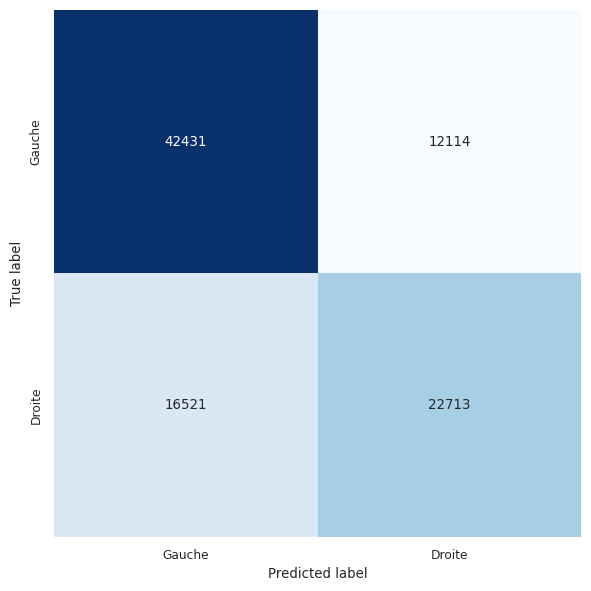

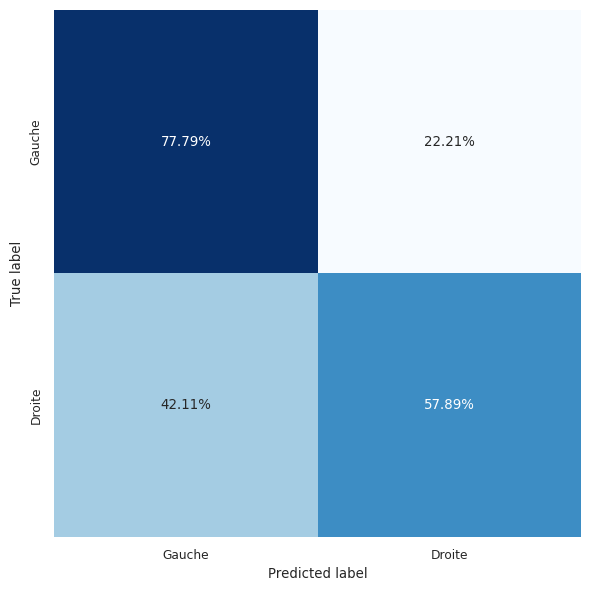

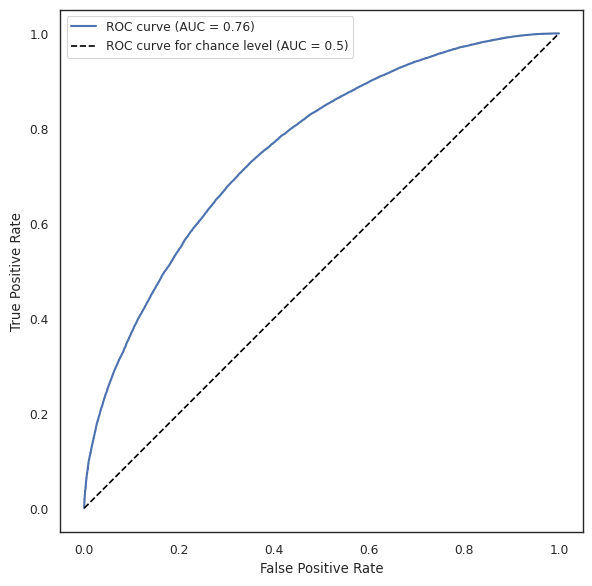

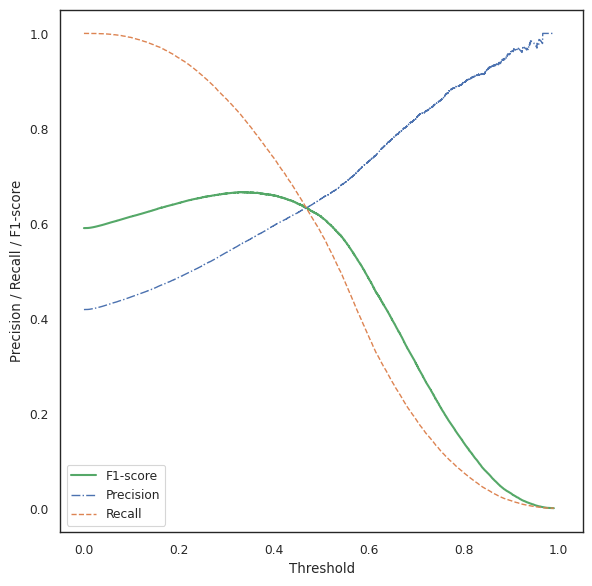

In [21]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## distilbert-base-multilingual-cased

### Experiment definition

In [26]:
MODEL_NAME = "distilbert-base-multilingual-cased"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
INPUT_DIM = 768
HIDDEN_DIM = 768
MIN_DELTA = 0.001


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    embed_dim=INPUT_DIM,
    inter_dim=HIDDEN_DIM,
    n_classes=NUM_CLASSES,
    dropout=0.2,
    freeze=True,
)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [27]:
trainer.fit(lit_model);

Missing logger folder: ../../results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_

Output()

Metric val_loss improved. New best score: 0.599
Epoch 0, global step 306: 'val_loss' reached 0.59882 (best 0.59882), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.597
Epoch 1, global step 612: 'val_loss' reached 0.59723 (best 0.59723), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.587
Epoch 2, global step 918: 'val_loss' reached 0.58719 (best 0.58719), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=2-step=918.ckpt' as top 1


Epoch 3, global step 1224: 'val_loss' was not in top 1


Epoch 4, global step 1530: 'val_loss' was not in top 1


Epoch 5, global step 1836: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.585
Epoch 6, global step 2142: 'val_loss' reached 0.58486 (best 0.58486), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Epoch 8, global step 2754: 'val_loss' was not in top 1


Epoch 9, global step 3060: 'val_loss' was not in top 1


Epoch 10, global step 3366: 'val_loss' was not in top 1


Epoch 11, global step 3672: 'val_loss' was not in top 1


Epoch 12, global step 3978: 'val_loss' reached 0.58394 (best 0.58394), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=12-step=3978.ckpt' as top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.577
Epoch 14, global step 4590: 'val_loss' reached 0.57740 (best 0.57740), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=14-step=4590.ckpt' as top 1


Epoch 15, global step 4896: 'val_loss' was not in top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.575
Epoch 19, global step 6120: 'val_loss' reached 0.57490 (best 0.57490), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=19-step=6120.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.573
Epoch 20, global step 6426: 'val_loss' reached 0.57260 (best 0.57260), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=20-step=6426.ckpt' as top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Epoch 22, global step 7038: 'val_loss' was not in top 1


Epoch 23, global step 7344: 'val_loss' was not in top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Epoch 26, global step 8262: 'val_loss' was not in top 1


Epoch 27, global step 8568: 'val_loss' was not in top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Epoch 29, global step 9180: 'val_loss' was not in top 1


Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.567
Epoch 30, global step 9486: 'val_loss' reached 0.56681 (best 0.56681), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=30-step=9486.ckpt' as top 1


Epoch 31, global step 9792: 'val_loss' reached 0.56590 (best 0.56590), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=31-step=9792.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.565
Epoch 32, global step 10098: 'val_loss' reached 0.56465 (best 0.56465), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=32-step=10098.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.563
Epoch 33, global step 10404: 'val_loss' reached 0.56310 (best 0.56310), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=33-step=10404.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.562
Epoch 34, global step 10710: 'val_loss' reached 0.56195 (best 0.56195), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=34-step=10710.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.560
Epoch 35, global step 11016: 'val_loss' reached 0.56010 (best 0.56010), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=35-step=11016.ckpt' as top 1


Epoch 36, global step 11322: 'val_loss' reached 0.55972 (best 0.55972), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=36-step=11322.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.556
Epoch 37, global step 11628: 'val_loss' reached 0.55605 (best 0.55605), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=37-step=11628.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.555
Epoch 38, global step 11934: 'val_loss' reached 0.55493 (best 0.55493), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=38-step=11934.ckpt' as top 1


Epoch 39, global step 12240: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.553
Epoch 40, global step 12546: 'val_loss' reached 0.55319 (best 0.55319), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=40-step=12546.ckpt' as top 1


Epoch 41, global step 12852: 'val_loss' was not in top 1


Epoch 42, global step 13158: 'val_loss' was not in top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.550
Epoch 43, global step 13464: 'val_loss' reached 0.55019 (best 0.55019), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=43-step=13464.ckpt' as top 1


Epoch 44, global step 13770: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.548
Epoch 45, global step 14076: 'val_loss' reached 0.54807 (best 0.54807), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=45-step=14076.ckpt' as top 1


Epoch 46, global step 14382: 'val_loss' was not in top 1


Epoch 47, global step 14688: 'val_loss' was not in top 1


Epoch 48, global step 14994: 'val_loss' reached 0.54764 (best 0.54764), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=48-step=14994.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.546
Epoch 49, global step 15300: 'val_loss' reached 0.54560 (best 0.54560), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=49-step=15300.ckpt' as top 1


Epoch 50, global step 15606: 'val_loss' was not in top 1


Epoch 51, global step 15912: 'val_loss' was not in top 1


Epoch 52, global step 16218: 'val_loss' was not in top 1


Epoch 53, global step 16524: 'val_loss' was not in top 1


Epoch 54, global step 16830: 'val_loss' was not in top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.543
Epoch 55, global step 17136: 'val_loss' reached 0.54301 (best 0.54301), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=55-step=17136.ckpt' as top 1


Epoch 56, global step 17442: 'val_loss' was not in top 1


Epoch 57, global step 17748: 'val_loss' reached 0.54213 (best 0.54213), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=57-step=17748.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.540
Epoch 58, global step 18054: 'val_loss' reached 0.54028 (best 0.54028), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=58-step=18054.ckpt' as top 1


Epoch 59, global step 18360: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.538
Epoch 60, global step 18666: 'val_loss' reached 0.53849 (best 0.53849), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=60-step=18666.ckpt' as top 1


Epoch 61, global step 18972: 'val_loss' reached 0.53828 (best 0.53828), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=61-step=18972.ckpt' as top 1


Epoch 62, global step 19278: 'val_loss' reached 0.53769 (best 0.53769), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=62-step=19278.ckpt' as top 1


Epoch 63, global step 19584: 'val_loss' was not in top 1


Epoch 64, global step 19890: 'val_loss' was not in top 1


Epoch 65, global step 20196: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.537
Epoch 66, global step 20502: 'val_loss' reached 0.53711 (best 0.53711), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=66-step=20502.ckpt' as top 1


Epoch 67, global step 20808: 'val_loss' reached 0.53671 (best 0.53671), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=67-step=20808.ckpt' as top 1


Epoch 68, global step 21114: 'val_loss' was not in top 1


Epoch 69, global step 21420: 'val_loss' was not in top 1


Epoch 70, global step 21726: 'val_loss' reached 0.53665 (best 0.53665), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=70-step=21726.ckpt' as top 1


Epoch 71, global step 22032: 'val_loss' was not in top 1


Epoch 72, global step 22338: 'val_loss' reached 0.53646 (best 0.53646), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=72-step=22338.ckpt' as top 1


Epoch 73, global step 22644: 'val_loss' was not in top 1


Epoch 74, global step 22950: 'val_loss' was not in top 1


Epoch 75, global step 23256: 'val_loss' reached 0.53635 (best 0.53635), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=75-step=23256.ckpt' as top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.537. Signaling Trainer to stop.
Epoch 76, global step 23562: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=75-step=23256.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilbert-base-multilingual-cased/lightning_logs/epoch=75-step=23256.ckpt


Output()

Metrics:  {'log_loss': 0.5345022033795411, 'accuracy': 0.719190863626185, 'balanced_accuracy': 0.702761249922448, 'recall': 0.6021308049141051, 'precision': 0.6877838593222313, 'f1_score': 0.642113560381615, 'AUC': 0.7934085916536433, 'jaccard_weighted': 0.4728772168621642, 'matthews_weighted': 0.4152087300788908, 'hamming_loss': 0.28080913637381505, 'confusion_matrix': [[43821, 10724], [15610, 23624]], 'confusion_matrix_true_normed': [[0.8033916949307911, 0.1966083050692089], [0.3978691950858949, 0.6021308049141051]], 'confusion_matrix_pred_normed': [[0.7373424643704464, 0.3122161406777687], [0.2626575356295536, 0.6877838593222313]], 'confusion_matrix_all_normed': [[0.4672794548886211, 0.11435395984175561], [0.1664551765320594, 0.25191140873756385]]}


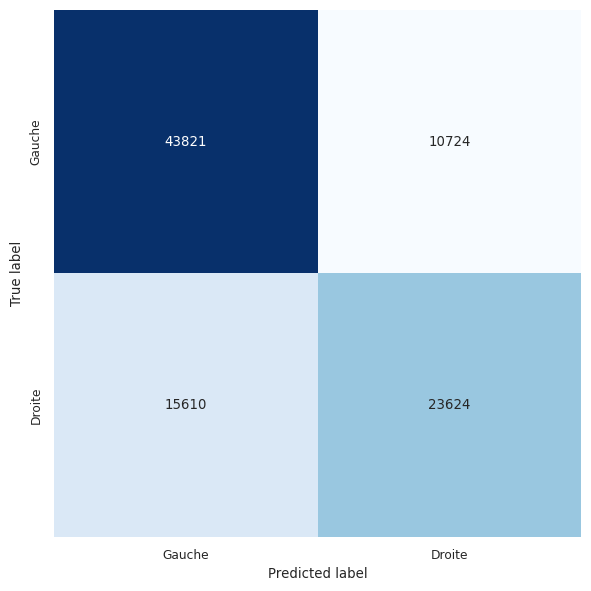

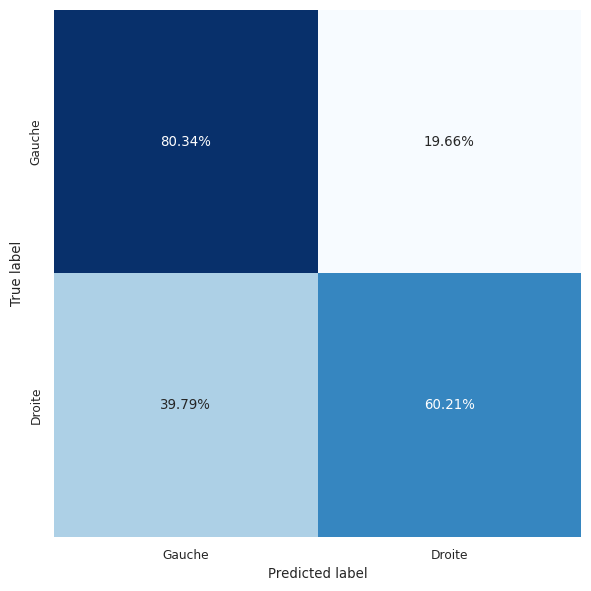

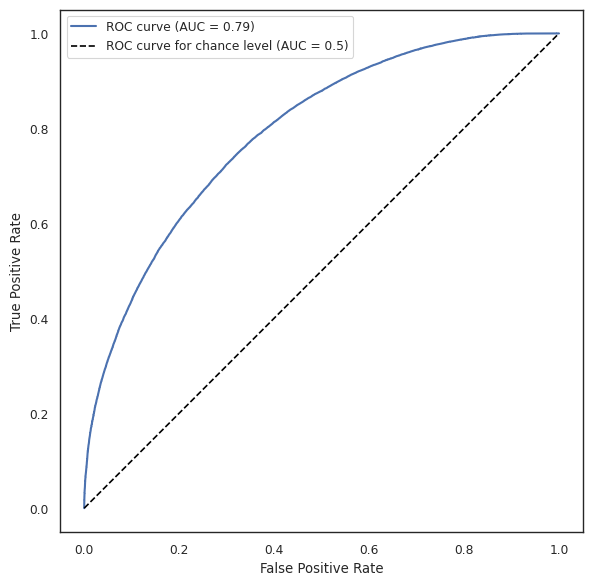

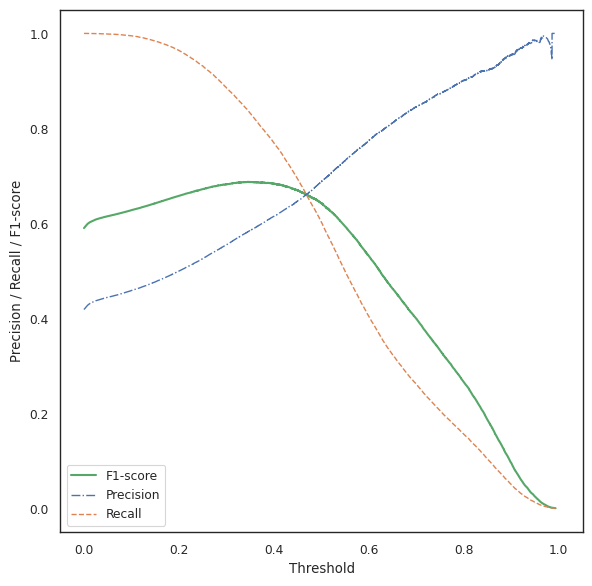

In [29]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## distilcamembert-base

### Experiment definition

In [19]:
MODEL_NAME = "distilcamembert-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
INPUT_DIM = 768
HIDDEN_DIM = 768
MIN_DELTA = 0.001


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    embed_dim=INPUT_DIM,
    inter_dim=HIDDEN_DIM,
    n_classes=NUM_CLASSES,
    dropout=0.2,
    freeze=True,
)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=1e-4,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [159]:
trainer.fit(lit_model);

Missing logger folder: ../../results/lm_model_selection/distilcamembert-base/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc.0       | D

Output()

Metric val_loss improved. New best score: 0.594
Epoch 0, global step 306: 'val_loss' reached 0.59417 (best 0.59417), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilcamembert-base/lightning_logs/epoch=0-step=306.ckpt' as top 1


Epoch 1, global step 612: 'val_loss' was not in top 1


Epoch 2, global step 918: 'val_loss' was not in top 1


Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.583
Epoch 3, global step 1224: 'val_loss' reached 0.58308 (best 0.58308), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilcamembert-base/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.570
Epoch 4, global step 1530: 'val_loss' reached 0.57038 (best 0.57038), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilcamembert-base/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Epoch 5, global step 1836: 'val_loss' was not in top 1


Epoch 6, global step 2142: 'val_loss' was not in top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Epoch 8, global step 2754: 'val_loss' was not in top 1


Epoch 9, global step 3060: 'val_loss' was not in top 1


Epoch 10, global step 3366: 'val_loss' was not in top 1


Epoch 11, global step 3672: 'val_loss' was not in top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.566
Epoch 12, global step 3978: 'val_loss' reached 0.56610 (best 0.56610), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilcamembert-base/lightning_logs/epoch=12-step=3978.ckpt' as top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' was not in top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Epoch 17, global step 5508: 'val_loss' reached 0.56589 (best 0.56589), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/distilcamembert-base/lightning_logs/epoch=17-step=5508.ckpt' as top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.566. Signaling Trainer to stop.
Epoch 22, global step 7038: 'val_loss' was not in top 1


### Evaluation and visualization

In [20]:
CKPT_PATH

PosixPath('../../results/lm_model_selection/distilcamembert-base/lightning_logs')

In [22]:
lit_model = LitModel.load_from_checkpoint(CKPT_PATH / "epoch=17-step=5508.ckpt", classifier=NET, criterion=nn.CrossEntropyLoss())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Metrics:  {'log_loss': 0.5651257909621573, 'accuracy': 0.7000501178302179, 'balanced_accuracy': 0.6895444075897792, 'recall': 0.6251975327522047, 'precision': 0.6462993702737596, 'f1_score': 0.6355733478435488, 'AUC': 0.7652342071075432, 'jaccard_weighted': 0.4658171597857875, 'matthews_weighted': 0.3809854824163463, 'hamming_loss': 0.29994988216978213, 'confusion_matrix': [[41121, 13424], [14705, 24529]], 'confusion_matrix_true_normed': [[0.7538912824273536, 0.24610871757264643], [0.37480246724779526, 0.6251975327522047]], 'confusion_matrix_pred_normed': [[0.7365922688353097, 0.35370062972624033], [0.2634077311646903, 0.6462993702737596]], 'confusion_matrix_all_normed': [[0.43848836093368454, 0.14314505379669223], [0.15680482837308993, 0.2615617568965333]]}


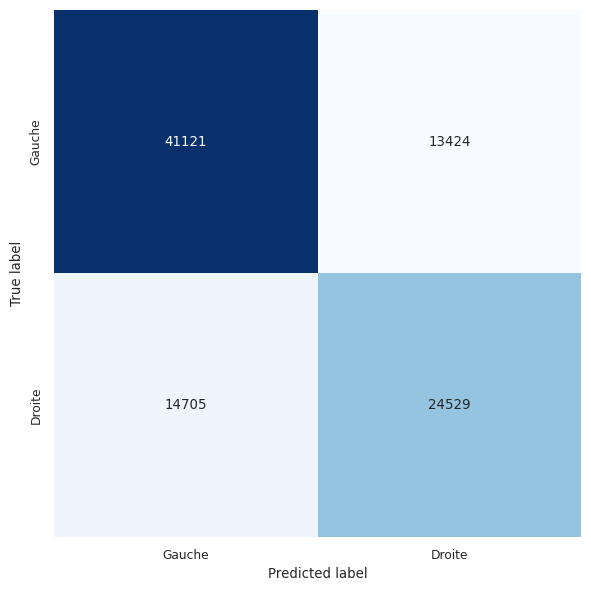

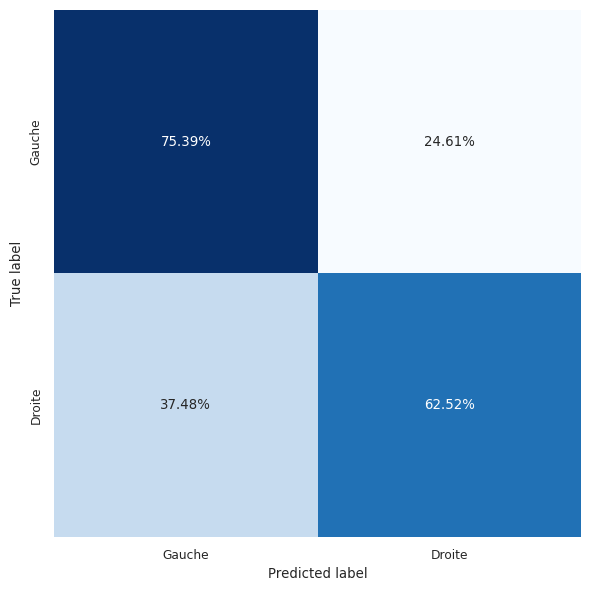

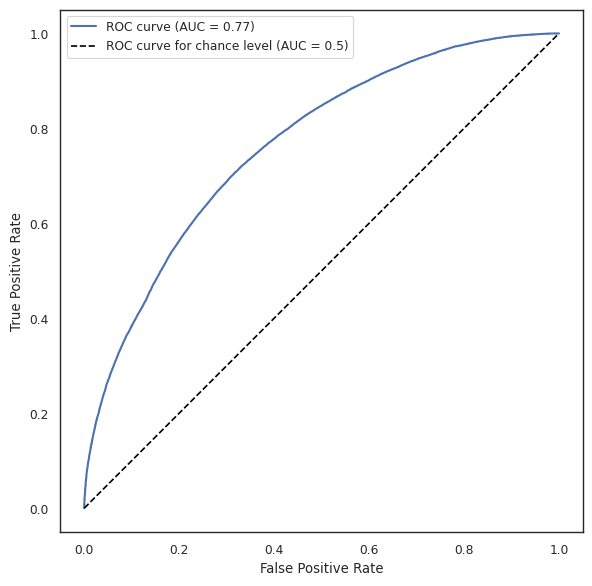

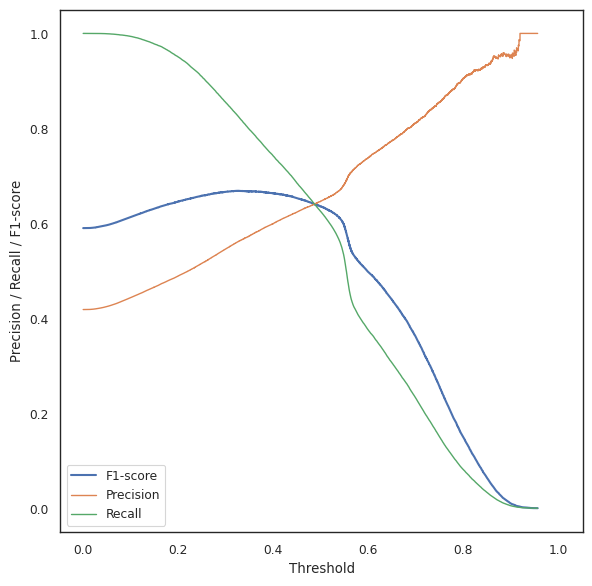

In [25]:
#### Prediction on test set
preds = trainer.predict(lit_model)


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## bert-tiny

### Experiment definition

In [37]:
MODEL_NAME = "bert-tiny"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
INPUT_DIM = 128
HIDDEN_DIM = 768
MIN_DELTA = 0.001


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    embed_dim=INPUT_DIM,
    inter_dim=HIDDEN_DIM,
    n_classes=NUM_CLASSES,
    dropout=0.2,
    freeze=True,
)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [38]:
trainer.fit(lit_model);

Missing logger folder: ../../results/lm_model_selection/bert-tiny/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 1.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 652 K  | [32]      | [32, 128]
2  | classifier.titre_fc            | Sequential | 99.1 K | [32, 128] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 128] | [32, 128]
4  | classifier.titre_fc.1          | Linear     | 99.1 K | [32, 128] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 60.5 K | [32]      | [32, 128]
7  | classifier.contexte_fc         | Sequential | 99.1 K | [32, 128] | [32, 768]
8  | classifier.contexte_fc.0       | Dropout    |

Output()

Metric val_loss improved. New best score: 0.625
Epoch 0, global step 306: 'val_loss' reached 0.62478 (best 0.62478), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-tiny/lightning_logs/epoch=0-step=306.ckpt' as top 1


Epoch 1, global step 612: 'val_loss' was not in top 1


Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.616
Epoch 2, global step 918: 'val_loss' reached 0.61614 (best 0.61614), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-tiny/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.613
Epoch 3, global step 1224: 'val_loss' reached 0.61255 (best 0.61255), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-tiny/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Epoch 4, global step 1530: 'val_loss' was not in top 1


Epoch 5, global step 1836: 'val_loss' was not in top 1


Epoch 6, global step 2142: 'val_loss' was not in top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Epoch 8, global step 2754: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.610
Epoch 9, global step 3060: 'val_loss' reached 0.61019 (best 0.61019), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-tiny/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Epoch 10, global step 3366: 'val_loss' reached 0.60945 (best 0.60945), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-tiny/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.606
Epoch 11, global step 3672: 'val_loss' reached 0.60597 (best 0.60597), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-tiny/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' was not in top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' reached 0.60516 (best 0.60516), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-tiny/lightning_logs/epoch=18-step=5814.ckpt' as top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.606. Signaling Trainer to stop.
Epoch 21, global step 6732: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-tiny/lightning_logs/epoch=18-step=5814.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-tiny/lightning_logs/epoch=18-step=5814.ckpt


Output()

Metrics:  {'log_loss': 0.6040693340870287, 'accuracy': 0.6680813401721067, 'balanced_accuracy': 0.6563209366229179, 'recall': 0.5842891369730336, 'precision': 0.6074030894782863, 'f1_score': 0.5956219551802534, 'AUC': 0.7193478317685408, 'jaccard_weighted': 0.42411796266489055, 'matthews_weighted': 0.3144907643620402, 'hamming_loss': 0.33191865982789326, 'confusion_matrix': [[39728, 14817], [16310, 22924]], 'confusion_matrix_true_normed': [[0.7283527362728023, 0.2716472637271977], [0.4157108630269664, 0.5842891369730336]], 'confusion_matrix_pred_normed': [[0.7089474999107749, 0.3925969105217138], [0.2910525000892252, 0.6074030894782863]], 'confusion_matrix_all_normed': [[0.42363428912656353, 0.1579991256038132], [0.17391953422408002, 0.24444705104554323]]}


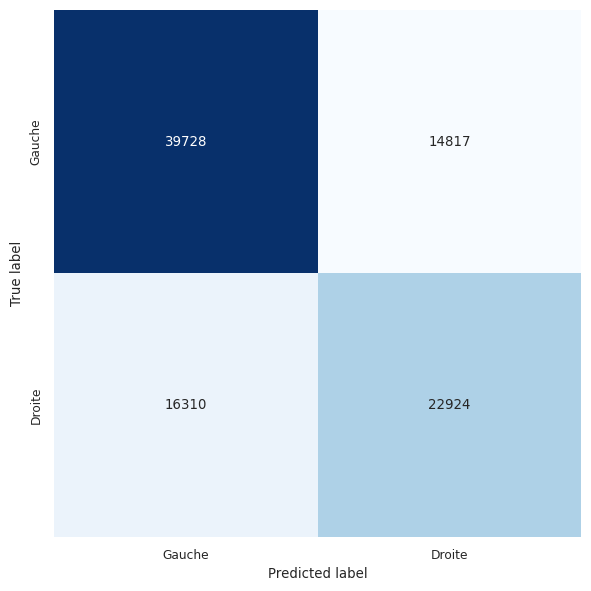

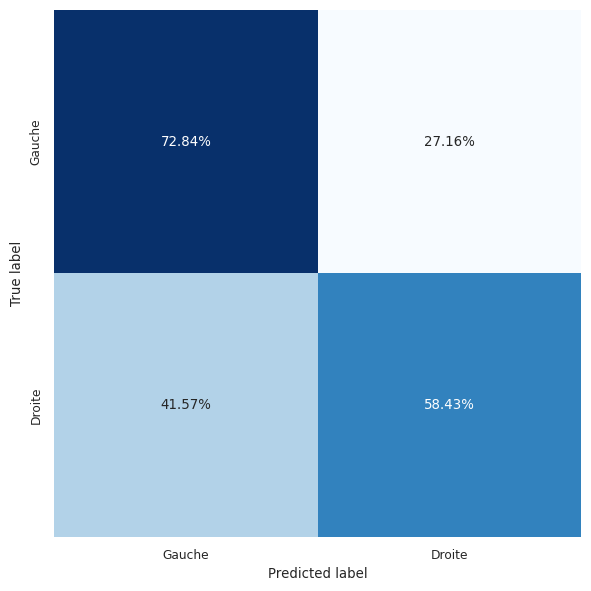

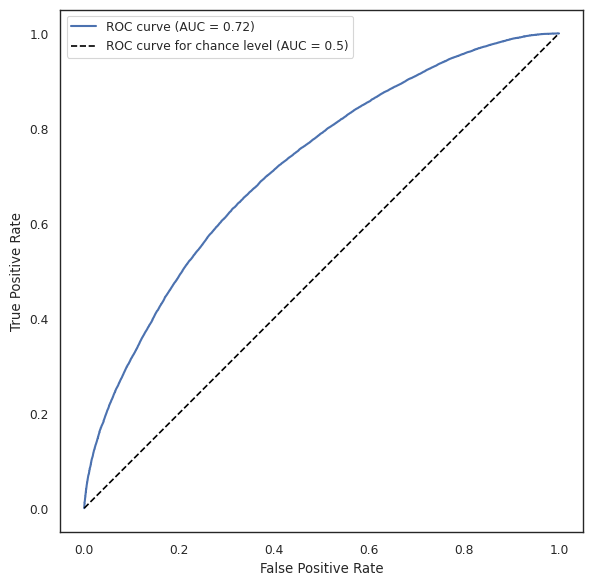

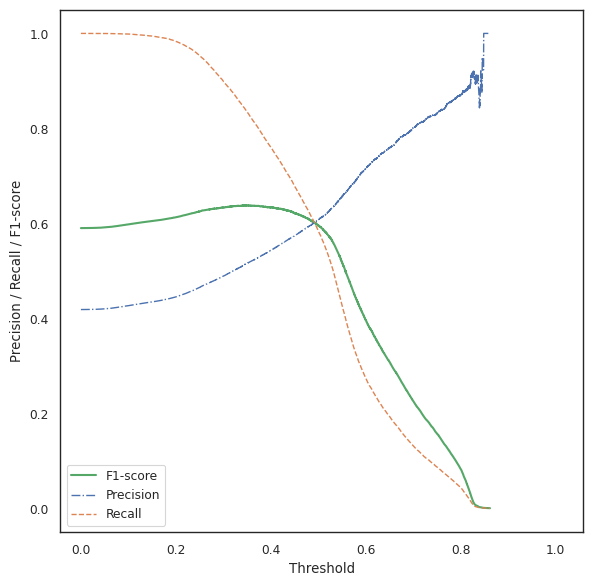

In [39]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## BERT base

### Experiment definition

In [4]:
MODEL_NAME = "bert-base-multilingual-cased"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
DROP_CENTER = True
MIN_DELTA = 0.001
INPUT_DIM = 768
HIDDEN_DIM = 1024
FREEZE = True

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, 2, dropout=0.2, freeze=FREEZE)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=5e-4,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [5]:
trainer.fit(lit_model)

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes   | Out sizes 
-----------------------------------------------------------------------------------------
0  | classifier                     | Net        | 7.7 M  | ?          | [32, 2]   
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]       | [32, 768] 
2  | classifier.titre_fc            | Sequential | 787 K  | [32, 768]  | [32, 1024]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768]  | [32, 768] 
4  | classifier.titre_fc.1          | Linear     | 787 K  | [32, 768]  | [

Output()

Metric val_loss improved. New best score: 0.634
Epoch 0, global step 306: 'val_loss' reached 0.63380 (best 0.63380), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.622
Epoch 1, global step 612: 'val_loss' reached 0.62170 (best 0.62170), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.617
Epoch 2, global step 918: 'val_loss' reached 0.61723 (best 0.61723), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=2-step=918-v1.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.616
Epoch 3, global step 1224: 'val_loss' reached 0.61561 (best 0.61561), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=3-step=1224-v1.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.612
Epoch 4, global step 1530: 'val_loss' reached 0.61231 (best 0.61231), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.611
Epoch 5, global step 1836: 'val_loss' reached 0.61094 (best 0.61094), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Epoch 6, global step 2142: 'val_loss' was not in top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.605
Epoch 8, global step 2754: 'val_loss' reached 0.60461 (best 0.60461), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Epoch 9, global step 3060: 'val_loss' was not in top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.602
Epoch 10, global step 3366: 'val_loss' reached 0.60195 (best 0.60195), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Epoch 11, global step 3672: 'val_loss' was not in top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Epoch 14, global step 4590: 'val_loss' reached 0.60129 (best 0.60129), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=14-step=4590.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.600
Epoch 15, global step 4896: 'val_loss' reached 0.60034 (best 0.60034), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.597
Epoch 17, global step 5508: 'val_loss' reached 0.59720 (best 0.59720), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=17-step=5508.ckpt' as top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.596
Epoch 20, global step 6426: 'val_loss' reached 0.59574 (best 0.59574), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=20-step=6426.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.594
Epoch 21, global step 6732: 'val_loss' reached 0.59428 (best 0.59428), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=21-step=6732.ckpt' as top 1


Epoch 22, global step 7038: 'val_loss' reached 0.59409 (best 0.59409), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=22-step=7038.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.592
Epoch 23, global step 7344: 'val_loss' reached 0.59224 (best 0.59224), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=23-step=7344.ckpt' as top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.588
Epoch 26, global step 8262: 'val_loss' reached 0.58835 (best 0.58835), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=26-step=8262.ckpt' as top 1


Epoch 27, global step 8568: 'val_loss' was not in top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Epoch 29, global step 9180: 'val_loss' was not in top 1


Epoch 30, global step 9486: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.586
Epoch 31, global step 9792: 'val_loss' reached 0.58599 (best 0.58599), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=31-step=9792.ckpt' as top 1


Epoch 32, global step 10098: 'val_loss' reached 0.58591 (best 0.58591), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=32-step=10098.ckpt' as top 1


Epoch 33, global step 10404: 'val_loss' reached 0.58500 (best 0.58500), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=33-step=10404.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.585
Epoch 34, global step 10710: 'val_loss' reached 0.58479 (best 0.58479), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=34-step=10710.ckpt' as top 1


Epoch 35, global step 11016: 'val_loss' reached 0.58444 (best 0.58444), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=35-step=11016.ckpt' as top 1


Epoch 36, global step 11322: 'val_loss' reached 0.58392 (best 0.58392), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=36-step=11322.ckpt' as top 1


Epoch 37, global step 11628: 'val_loss' was not in top 1


Epoch 38, global step 11934: 'val_loss' was not in top 1


Epoch 39, global step 12240: 'val_loss' was not in top 1


Epoch 40, global step 12546: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.584
Epoch 41, global step 12852: 'val_loss' reached 0.58364 (best 0.58364), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=41-step=12852.ckpt' as top 1


Epoch 42, global step 13158: 'val_loss' reached 0.58336 (best 0.58336), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=42-step=13158.ckpt' as top 1


Epoch 43, global step 13464: 'val_loss' reached 0.58330 (best 0.58330), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=43-step=13464.ckpt' as top 1


Epoch 44, global step 13770: 'val_loss' was not in top 1


Epoch 45, global step 14076: 'val_loss' was not in top 1


Epoch 46, global step 14382: 'val_loss' was not in top 1


Epoch 47, global step 14688: 'val_loss' reached 0.58321 (best 0.58321), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=47-step=14688.ckpt' as top 1


Epoch 48, global step 14994: 'val_loss' reached 0.58316 (best 0.58316), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=48-step=14994.ckpt' as top 1


Epoch 49, global step 15300: 'val_loss' reached 0.58287 (best 0.58287), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/bert-base-multilingual-cased/lightning_logs/epoch=49-step=15300.ckpt' as top 1


Epoch 50, global step 15606: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.584. Signaling Trainer to stop.
Epoch 51, global step 15912: 'val_loss' was not in top 1


### Evaluation and visualization

Metrics:  {'log_loss': 0.5826776604976673, 'accuracy': 0.6827754614572559, 'balanced_accuracy': 0.6632325971027924, 'recall': 0.5435336697762145, 'precision': 0.6429971355344489, 'f1_score': 0.5890965344825205, 'AUC': 0.743836685844024, 'jaccard_weighted': 0.4175314249911893, 'matthews_weighted': 0.3368365262963254, 'hamming_loss': 0.31722453854274413, 'confusion_matrix': [[42705, 11840], [17909, 21325]], 'confusion_matrix_true_normed': [[0.7829315244293702, 0.21706847557062975], [0.45646633022378547, 0.5435336697762145]], 'confusion_matrix_pred_normed': [[0.7045402052331144, 0.357002864465551], [0.29545979476688555, 0.6429971355344489]], 'confusion_matrix_all_normed': [[0.455379136053914, 0.12625427867646274], [0.19097025986628136, 0.2273963254033419]]}


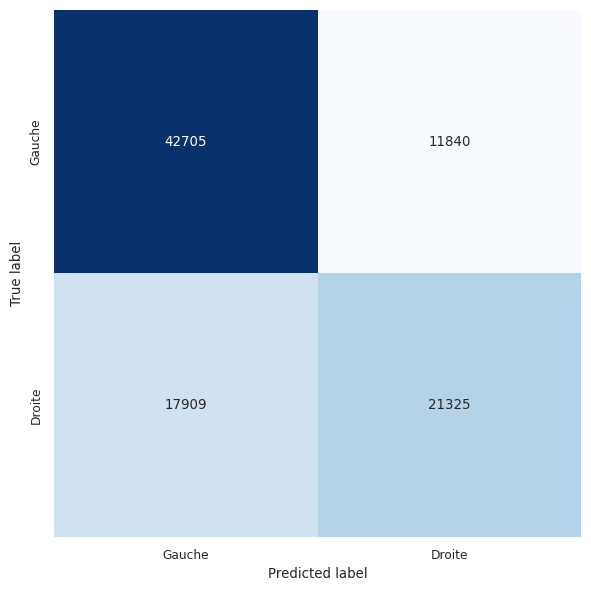

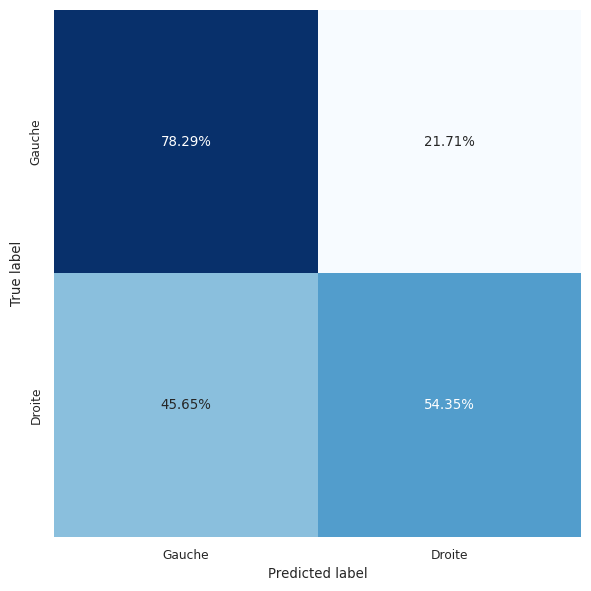

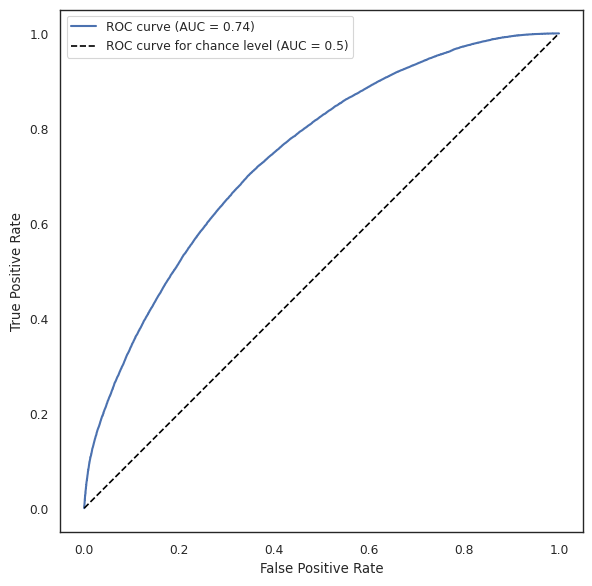

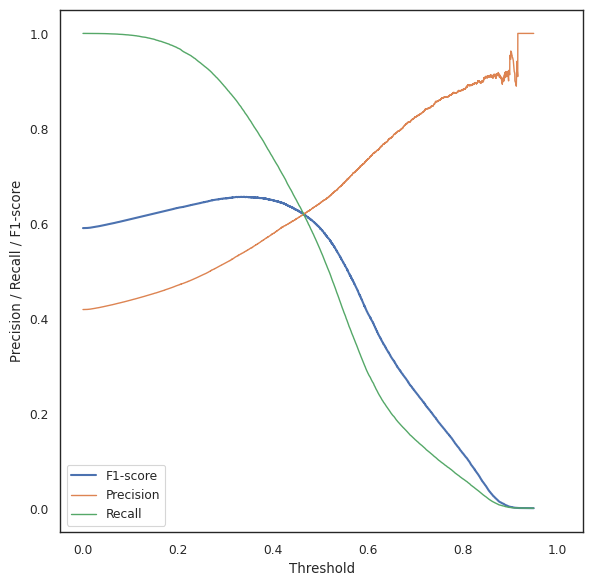

In [8]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## CamemBERT base unfrozen embeddings

### Experiment definition

In [64]:
MODEL_NAME = "camembert-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}_unfrozen"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
DROP_CENTER = True
MIN_DELTA = 0.001
INPUT_DIM = 768
HIDDEN_DIM = 1024

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, 2, dropout=0.2, freeze=False)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [65]:
trainer.fit(lit_model)

Missing logger folder: ../../results/lm_model_selection/camembert-base_unfrozen/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes   | Out sizes 
-----------------------------------------------------------------------------------------
0  | classifier                     | Net        | 7.7 M  | ?          | [32, 2]   
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]       | [32, 768] 
2  | classifier.titre_fc            | Sequential | 787 K  | [32, 768]  | [32, 1024]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768]  | [32, 768] 
4  | classifier.titre_fc.1          | Linear     | 787 K  | [32, 768]  | [32, 1024]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 1024] | [32, 1024]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]       | [32, 768] 
7  | classifier.contexte_fc         | Sequential | 787 K  | [32, 768]  | [32, 1024]
8  | classifier.

Output()

Metric val_loss improved. New best score: 0.561
Epoch 0, global step 306: 'val_loss' reached 0.56054 (best 0.56054), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_unfrozen/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.552
Epoch 1, global step 612: 'val_loss' reached 0.55244 (best 0.55244), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_unfrozen/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.541
Epoch 2, global step 918: 'val_loss' reached 0.54112 (best 0.54112), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_unfrozen/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.537
Epoch 3, global step 1224: 'val_loss' reached 0.53730 (best 0.53730), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_unfrozen/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Epoch 4, global step 1530: 'val_loss' was not in top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.533
Epoch 5, global step 1836: 'val_loss' reached 0.53303 (best 0.53303), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_unfrozen/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.531
Epoch 6, global step 2142: 'val_loss' reached 0.53061 (best 0.53061), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_unfrozen/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.528
Epoch 8, global step 2754: 'val_loss' reached 0.52845 (best 0.52845), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_unfrozen/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.523
Epoch 9, global step 3060: 'val_loss' reached 0.52317 (best 0.52317), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_unfrozen/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Epoch 10, global step 3366: 'val_loss' was not in top 1


Epoch 11, global step 3672: 'val_loss' was not in top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' was not in top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.523. Signaling Trainer to stop.
Epoch 19, global step 6120: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_unfrozen/lightning_logs/epoch=9-step=3060.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/camembert-base_unfrozen/lightning_logs/epoch=9-step=3060.ckpt


Output()

Metrics:  {'log_loss': 0.5192585956763252, 'accuracy': 0.7283506968511074, 'balanced_accuracy': 0.7147958884729844, 'recall': 0.6317734617933425, 'precision': 0.692084322211364, 'f1_score': 0.6605551039987209, 'AUC': 0.8062381821992914, 'jaccard_weighted': 0.4931558632764315, 'matthews_weighted': 0.4361672719903336, 'hamming_loss': 0.27164930314889263, 'confusion_matrix': [[43517, 11028], [14447, 24787]], 'confusion_matrix_true_normed': [[0.7978183151526262, 0.20218168484737373], [0.3682265382066575, 0.6317734617933425]], 'confusion_matrix_pred_normed': [[0.7507590918501139, 0.30791567778863604], [0.24924090814988614, 0.692084322211364]], 'confusion_matrix_all_normed': [[0.46403779097665787, 0.11759562375371885], [0.15405367939517375, 0.2643129058744495]]}


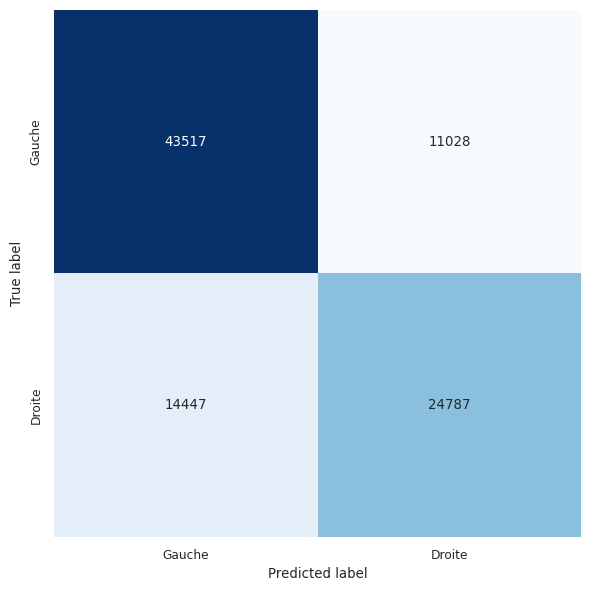

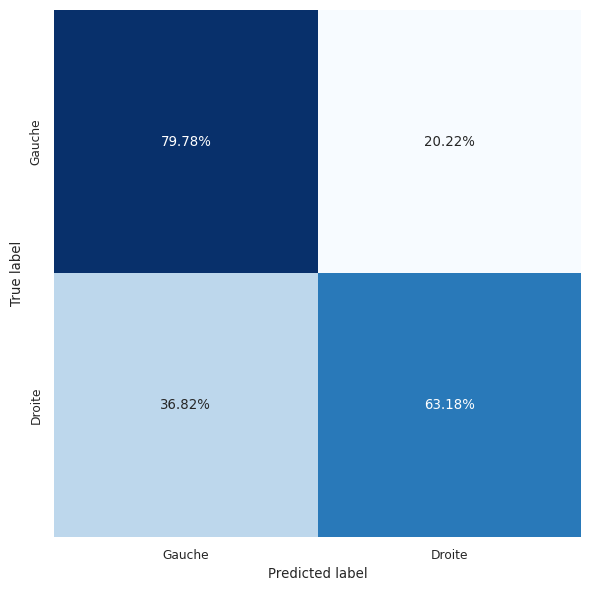

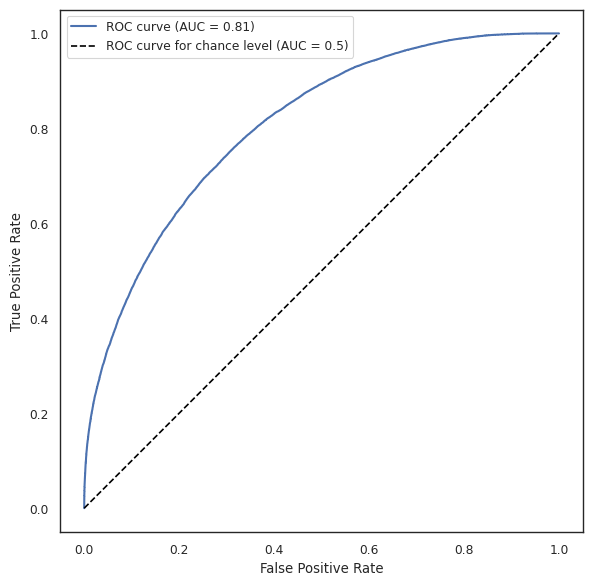

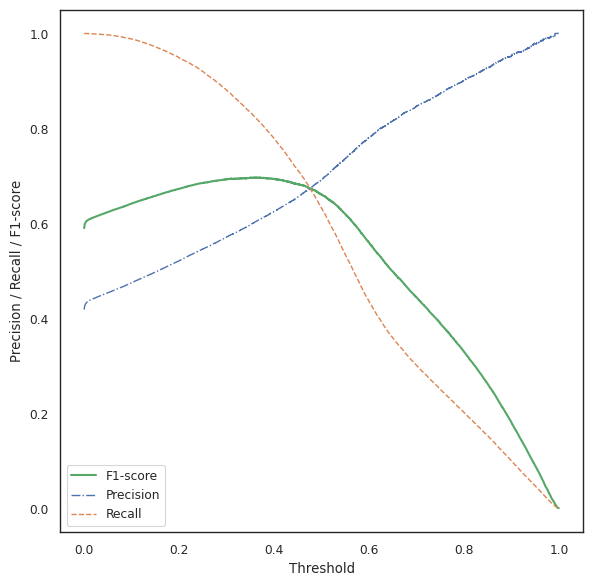

In [66]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

### Embeddings visualization

#### Titre

In [144]:
folder_path = Path(MODEL_FOLDER)
f = folder_path / "titre_regexed/embeddings.pkl"

with open(f, "rb") as f:
    embs = pickle.load(f)

titre_emb = NET.titre_embeddings.weight.detach().cpu().numpy()
titre_to_int = embs["label_to_int"]

data = lit_model.test_dataloader().dataset

titre = data.text["titre_regexed"]
labels = data.labels

tmp_df = pd.DataFrame({"titre": titre, "label": labels})
color = tmp_df.sort_values("titre").groupby("titre")["label"].mean().to_dict()
size = tmp_df.sort_values("titre").groupby("titre")["label"].count().to_dict()
color_2 = {k: v for k, v in color.items() if (v != 0) and (v != 1)}


def plot_emb_proj(
    projection, embedding_dict, label_to_int, color, size, var, width=1200, height=1200
):
    idx = list(color.keys())
    embedding_df = pd.DataFrame(embedding_dict.T[idx], index=idx)
    int_to_label = {v: k for k, v in label_to_int.items()}

    if projection == "umap":
        fit = umap.UMAP()
    elif projection == "tsne":
        fit = TSNE(n_components=2, random_state=0)
    elif projection == "pca":
        fit = PCA(n_components=2)

    proj = fit.fit_transform(embedding_df)
    proj_df = pd.DataFrame(proj, columns=[f"{projection}-x", f"{projection}-y"])
    proj_df[var] = embedding_df.index
    proj_df[var] = proj_df[var].map(int_to_label)
    proj_df["Orientation"] = embedding_df.index.map(color)
    proj_df["Size"] = embedding_df.index.map(size)
    proj_df["Size"] = np.log(proj_df["Size"] + 1)

    fig = px.scatter(
        proj_df,
        x=f"{projection}-x",
        y=f"{projection}-y",
        size="Size",
        color="Orientation",
        hover_name=var,
        width=width,
        height=height,
        color_continuous_scale=px.colors.diverging.Temps,
    )

    return fig

In [145]:
pca_fig = plot_emb_proj("pca", titre_emb.T, titre_to_int, color, size, "Titre")
pca_fig.write_html(Path(RESULTS_PATH) / "titre_pca.html")
pca_fig.write_image(Path(RESULTS_PATH) / "titre_pca.png")

umap_fig = plot_emb_proj("umap", titre_emb.T, titre_to_int, color, size, "Titre")
umap_fig.write_html(Path(RESULTS_PATH) / "titre_umap.html")
umap_fig.write_image(Path(RESULTS_PATH) / "titre_umap.png")

tsne_fig = plot_emb_proj("tsne", titre_emb.T, titre_to_int, color, size, "Titre")
tsne_fig.write_html(Path(RESULTS_PATH) / "titre_tsne.html")
tsne_fig.write_image(Path(RESULTS_PATH) / "titre_tsne.png")

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
umap_fig

## RoBERTa base with center

### Experiment definition

In [171]:
MODEL_NAME = "xlm-roberta-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}_center"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 3
DROP_CENTER = NUM_CLASSES == 2
MIN_DELTA = 0.00
INPUT_DIM = 768
HIDDEN_DIM = 1024
FREEZE = True

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=20,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=0.2, freeze=FREEZE)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [172]:
trainer.fit(lit_model)

Missing logger folder: ../../results/lm_model_selection/xlm-roberta-base_center/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes   | Out sizes 
-----------------------------------------------------------------------------------------
0  | classifier                     | Net        | 7.7 M  | ?          | [32, 3]   
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]       | [32, 768] 
2  | classifier.titre_fc            | Sequential | 787 K  | [32, 768]  | [32, 1024]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768]  | [32, 768] 
4  | classifier.titre_fc.1          | Linear     | 787 K  | [32, 768]  | [32, 1024]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 1024] | [32, 1024]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]       | [32, 768] 
7  | classifier.contexte_fc         | Sequential | 787 K  | [32, 768]  | [32, 1024]
8  | classifier.

Output()

Metric val_loss improved. New best score: 0.984
Epoch 0, global step 356: 'val_loss' reached 0.98369 (best 0.98369), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=0-step=356.ckpt' as top 1


Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 0.919
Epoch 1, global step 712: 'val_loss' reached 0.91879 (best 0.91879), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=1-step=712.ckpt' as top 1


Epoch 2, global step 1068: 'val_loss' was not in top 1


Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.886
Epoch 3, global step 1424: 'val_loss' reached 0.88615 (best 0.88615), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=3-step=1424.ckpt' as top 1


Epoch 4, global step 1780: 'val_loss' was not in top 1


Epoch 5, global step 2136: 'val_loss' was not in top 1


Epoch 6, global step 2492: 'val_loss' was not in top 1


Epoch 7, global step 2848: 'val_loss' was not in top 1


Epoch 8, global step 3204: 'val_loss' was not in top 1


Epoch 9, global step 3560: 'val_loss' was not in top 1


Epoch 10, global step 3916: 'val_loss' was not in top 1


Epoch 11, global step 4272: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.885
Epoch 12, global step 4628: 'val_loss' reached 0.88471 (best 0.88471), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=12-step=4628.ckpt' as top 1


Epoch 13, global step 4984: 'val_loss' was not in top 1


Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.875
Epoch 14, global step 5340: 'val_loss' reached 0.87480 (best 0.87480), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=14-step=5340.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.871
Epoch 15, global step 5696: 'val_loss' reached 0.87120 (best 0.87120), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=15-step=5696.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.871
Epoch 16, global step 6052: 'val_loss' reached 0.87055 (best 0.87055), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=16-step=6052.ckpt' as top 1


Epoch 17, global step 6408: 'val_loss' was not in top 1


Epoch 18, global step 6764: 'val_loss' was not in top 1


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.866
Epoch 19, global step 7120: 'val_loss' reached 0.86572 (best 0.86572), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=19-step=7120.ckpt' as top 1


Epoch 20, global step 7476: 'val_loss' was not in top 1


Epoch 21, global step 7832: 'val_loss' was not in top 1


Epoch 22, global step 8188: 'val_loss' was not in top 1


Epoch 23, global step 8544: 'val_loss' was not in top 1


Epoch 24, global step 8900: 'val_loss' was not in top 1


Epoch 25, global step 9256: 'val_loss' was not in top 1


Epoch 26, global step 9612: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.865
Epoch 27, global step 9968: 'val_loss' reached 0.86497 (best 0.86497), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=27-step=9968.ckpt' as top 1


Epoch 28, global step 10324: 'val_loss' was not in top 1


Epoch 29, global step 10680: 'val_loss' was not in top 1


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.856
Epoch 30, global step 11036: 'val_loss' reached 0.85560 (best 0.85560), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=30-step=11036.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.854
Epoch 31, global step 11392: 'val_loss' reached 0.85352 (best 0.85352), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=31-step=11392.ckpt' as top 1


Epoch 32, global step 11748: 'val_loss' was not in top 1


Epoch 33, global step 12104: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.851
Epoch 34, global step 12460: 'val_loss' reached 0.85127 (best 0.85127), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=34-step=12460.ckpt' as top 1


Epoch 35, global step 12816: 'val_loss' was not in top 1


Epoch 36, global step 13172: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.850
Epoch 37, global step 13528: 'val_loss' reached 0.85018 (best 0.85018), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=37-step=13528.ckpt' as top 1


Epoch 38, global step 13884: 'val_loss' was not in top 1


Epoch 39, global step 14240: 'val_loss' was not in top 1


Epoch 40, global step 14596: 'val_loss' was not in top 1


Epoch 41, global step 14952: 'val_loss' was not in top 1


Epoch 42, global step 15308: 'val_loss' was not in top 1


Epoch 43, global step 15664: 'val_loss' was not in top 1


Epoch 44, global step 16020: 'val_loss' was not in top 1


Epoch 45, global step 16376: 'val_loss' was not in top 1


Epoch 46, global step 16732: 'val_loss' was not in top 1


Epoch 47, global step 17088: 'val_loss' was not in top 1


Epoch 48, global step 17444: 'val_loss' was not in top 1


Epoch 49, global step 17800: 'val_loss' was not in top 1


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.845
Epoch 50, global step 18156: 'val_loss' reached 0.84506 (best 0.84506), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=50-step=18156.ckpt' as top 1


Epoch 51, global step 18512: 'val_loss' was not in top 1


Epoch 52, global step 18868: 'val_loss' was not in top 1


Epoch 53, global step 19224: 'val_loss' was not in top 1


Epoch 54, global step 19580: 'val_loss' was not in top 1


Epoch 55, global step 19936: 'val_loss' was not in top 1


Epoch 56, global step 20292: 'val_loss' was not in top 1


Epoch 57, global step 20648: 'val_loss' was not in top 1


Epoch 58, global step 21004: 'val_loss' was not in top 1


Epoch 59, global step 21360: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.843
Epoch 60, global step 21716: 'val_loss' reached 0.84343 (best 0.84343), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=60-step=21716.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.842
Epoch 61, global step 22072: 'val_loss' reached 0.84208 (best 0.84208), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=61-step=22072.ckpt' as top 1


Epoch 62, global step 22428: 'val_loss' was not in top 1


Epoch 63, global step 22784: 'val_loss' was not in top 1


Epoch 64, global step 23140: 'val_loss' was not in top 1


Epoch 65, global step 23496: 'val_loss' was not in top 1


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.842
Epoch 66, global step 23852: 'val_loss' reached 0.84174 (best 0.84174), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=66-step=23852.ckpt' as top 1


Epoch 67, global step 24208: 'val_loss' was not in top 1


Epoch 68, global step 24564: 'val_loss' was not in top 1


Epoch 69, global step 24920: 'val_loss' was not in top 1


Epoch 70, global step 25276: 'val_loss' was not in top 1


Epoch 71, global step 25632: 'val_loss' was not in top 1


Epoch 72, global step 25988: 'val_loss' was not in top 1


Epoch 73, global step 26344: 'val_loss' was not in top 1


Epoch 74, global step 26700: 'val_loss' was not in top 1


Epoch 75, global step 27056: 'val_loss' was not in top 1


Epoch 76, global step 27412: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.841
Epoch 77, global step 27768: 'val_loss' reached 0.84053 (best 0.84053), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=77-step=27768.ckpt' as top 1


Epoch 78, global step 28124: 'val_loss' was not in top 1


Epoch 79, global step 28480: 'val_loss' was not in top 1


Epoch 80, global step 28836: 'val_loss' was not in top 1


Epoch 81, global step 29192: 'val_loss' was not in top 1


Epoch 82, global step 29548: 'val_loss' was not in top 1


Epoch 83, global step 29904: 'val_loss' was not in top 1


Epoch 84, global step 30260: 'val_loss' was not in top 1


Epoch 85, global step 30616: 'val_loss' was not in top 1


Epoch 86, global step 30972: 'val_loss' was not in top 1


Epoch 87, global step 31328: 'val_loss' was not in top 1


Epoch 88, global step 31684: 'val_loss' was not in top 1


Epoch 89, global step 32040: 'val_loss' was not in top 1


Epoch 90, global step 32396: 'val_loss' was not in top 1


Epoch 91, global step 32752: 'val_loss' was not in top 1


Epoch 92, global step 33108: 'val_loss' was not in top 1


Epoch 93, global step 33464: 'val_loss' was not in top 1


Epoch 94, global step 33820: 'val_loss' was not in top 1


Epoch 95, global step 34176: 'val_loss' was not in top 1


Epoch 96, global step 34532: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 20 records. Best score: 0.841. Signaling Trainer to stop.
Epoch 97, global step 34888: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=77-step=27768.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/lm_model_selection/xlm-roberta-base_center/lightning_logs/epoch=77-step=27768.ckpt


Output()

Metrics:  {'log_loss': 0.8391680826314784, 'accuracy': 0.6132371277688132, 'balanced_accuracy': 0.47321077282044555, 'recall_weighted': 0.6132371277688132, 'recall_micro': 0.6132371277688132, 'recall_macro': 0.47321077282044555, 'precision_weighted': 0.6032834571645712, 'precision_micro': 0.6132371277688132, 'precision_macro': 0.5885613107259425, 'f1_score_weighted': 0.5706293238905625, 'f1_score_micro': 0.6132371277688132, 'f1_score_macro': 0.4475046580413338, 'AUC_weighted_ovr': 0.7500809930020298, 'AUC_macro_ovr': 0.7484733551942601, 'AUC_weighted_ovo': 0.7410273422848379, 'AUC_macro_ovo': 0.7382431423203258, 'jaccard_weighted': 0.42456358676449596, 'jaccard_micro': 0.44220763336572855, 'jaccard_macro': 0.3292442033692761, 'matthews_weighted': 0.3150805193470242, 'hamming_loss': 0.3867628722311867, 'confusion_matrix': [[41707, 179, 12659], [10350, 331, 4612], [14290, 95, 24849]], 'confusion_matrix_true_normed': [[0.7646347052892107, 0.0032816940141167845, 0.23208360069667247], [0.67

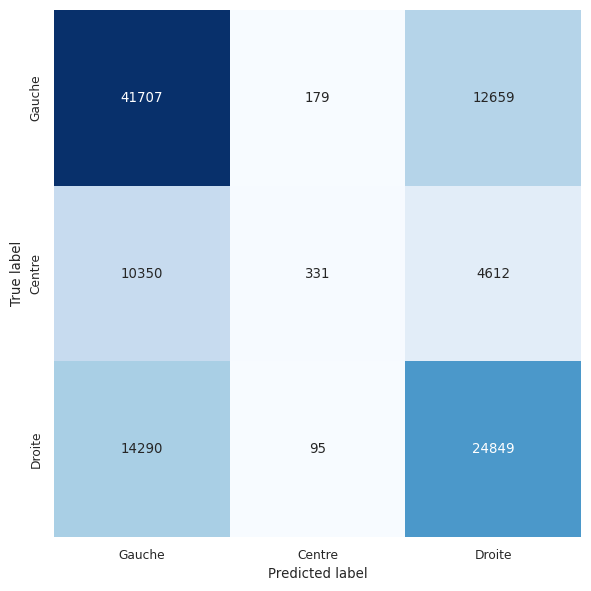

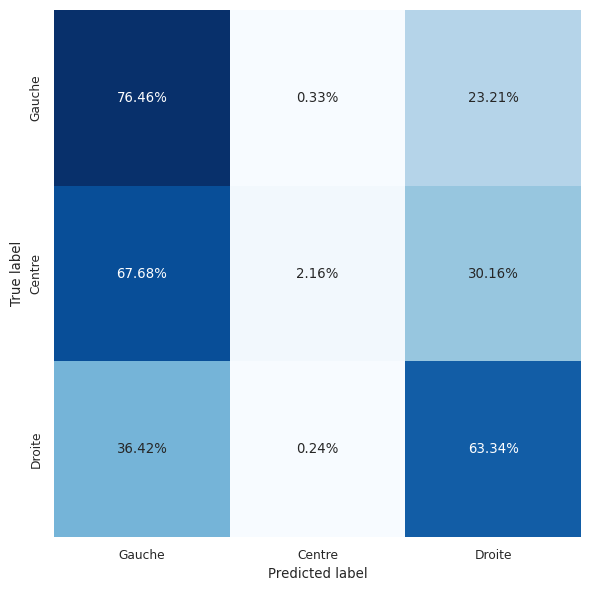

Micro-averaged One-vs-Rest ROC AUC score:
0.80
Macro-averaged One-vs-Rest ROC AUC score:
0.75


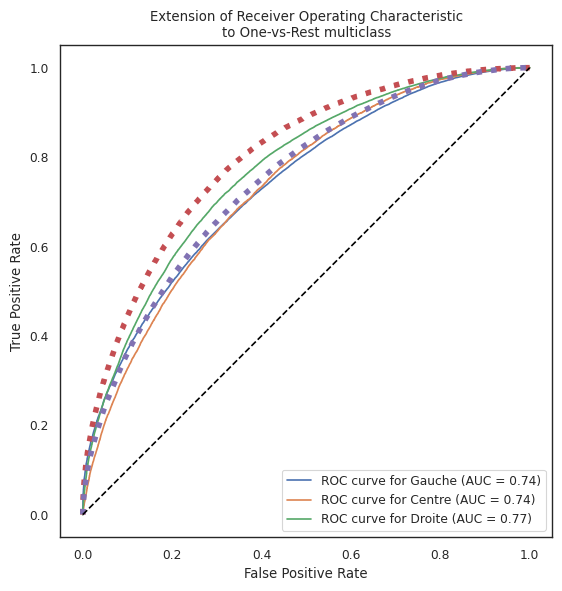

/home/gwatk/Documents/MVA/DL/NLP_Assemblee/nlp_assemblee/simple_visualisation.py:116: RuntimeWarning:

invalid value encountered in divide

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


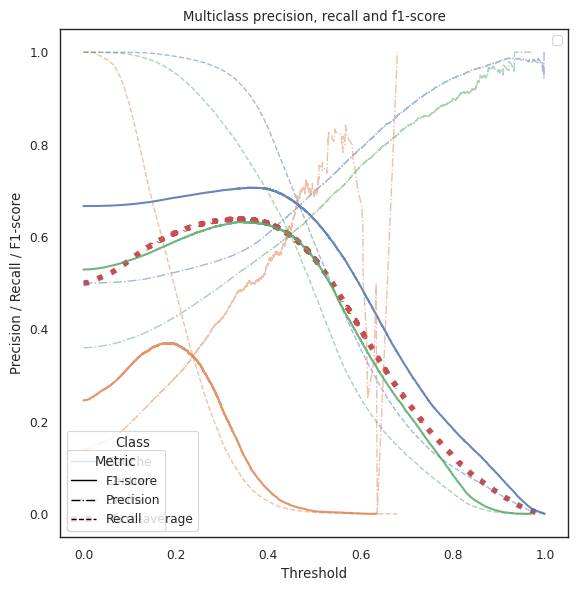

In [175]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## Compare metrics

In [26]:
def parse_tensorboard(path):
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()

    scalars = ea.Tags()["scalars"]

    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}


EXP_DIR = "../../results/lm_model_selection"
EVENT_FILES = glob(f"{EXP_DIR}/**/lightning_logs/version_*")

In [27]:
res_dict = {}

for f in EVENT_FILES:
    name = Path(f).parent.parent.name
    tmp = parse_tensorboard(f)
    res_dict[name] = tmp

In [29]:
res_dict.keys()

dict_keys(['xlm-roberta-base', 'distilbert-base-multilingual-cased_retest', 'paraphrase-multilingual-MiniLM-L12-v2', 'camembert-base_unfrozen', 'camembert-base', 'distiluse-base-multilingual-cased-v2', 'bert-base-multilingual-cased', 'camembert-base_binary', 'bert-tiny', 'distilbert-base-multilingual-cased', 'distilcamembert-base', 'xlm-roberta-base_unfrozen', 'xlm-roberta-base_center', 'paraphrase-multilingual-mpnet-base-v2'])

In [31]:
models = {
    'xlm-roberta-base': 'xlm-roberta-base',
    'distilbert-base-multilingual-cased_retest': 'distilbert-base-multilingual-cased',
    'paraphrase-multilingual-MiniLM-L12-v2': 'paraphrase-multilingual-MiniLM-L12-v2',
    # 'camembert-base_unfrozen': 'camembert-base_unfrozen',
    'distiluse-base-multilingual-cased-v2': 'distiluse-base-multilingual-cased-v2',
    'bert-base-multilingual-cased': 'bert-base-multilingual-cased',
    'camembert-base_binary': 'camembert-base',
    'bert-tiny': 'bert-tiny',
    # 'distilbert-base-multilingual-cased': 'distilbert-base-multilingual-cased',
    'distilcamembert-base': 'distilcamembert-base',
    # 'xlm-roberta-base_unfrozen': 'xlm-roberta-base_unfrozen',
    'paraphrase-multilingual-mpnet-base-v2': 'paraphrase-multilingual-mpnet-base-v2',
}

In [32]:
logs = {}

logs_files = glob(f"{EXP_DIR}/**/logs.json")
logs_files = [Path(f) for f in logs_files]

logs_index = [f for f in logs_files if f.parent.name in models]
logs_names = [m.parent.name for m in logs_index]

for f, n in zip(logs_index, logs_names):
    with open(f, "r") as file:
        logs[models[n]] = json.load(file)

log_df = pd.DataFrame()

for model in logs:
    try:
        tmp = {
            "model": model,
            "last_epoch": logs[model]["last_epoch"],
            "trainable_parameters": logs[model]["trainable_parameters"],
            "total_parameters": logs[model]["total_parameters"],
            "model_size": logs[model]["model_size"],
            "time_elapsed": logs[model]["time_elapsed"],
            "log_loss": logs[model]["metrics"]["log_loss"],
            "accuracy": logs[model]["metrics"]["accuracy"],
            "recall": logs[model]["metrics"]["recall"],
            "precision": logs[model]["metrics"]["precision"],
            "f1_score": logs[model]["metrics"]["f1_score"],
            "AUC": logs[model]["metrics"]["AUC"],
            "jaccard": logs[model]["metrics"]["jaccard_weighted"],
            "matthews_corrcoef": logs[model]["metrics"]["matthews_weighted"],
            "confusion_matrix": logs[model]["metrics"]["confusion_matrix"],
            "optimizer_type": logs[model]["hparams"]["optimizer_type"],
            "optimizer_kwargs": logs[model]["hparams"]["optimizer_kwargs"],
            "learning_rate": logs[model]["hparams"]["learning_rate"],
            "scheduler": logs[model]["hparams"]["scheduler_kwargs"].get("scheduler"),
            "scheduler_kwargs": logs[model]["hparams"]["scheduler_kwargs"],
            "batch_size": logs[model]["hparams"]["batch_size"],
            "ckpt_path": logs[model]["ckpt_path"],
        }

        log_df = log_df.append(tmp, ignore_index=True)
    except Exception as e:
        print(e)
        print(f"Error with {model}")
        continue

/tmp/ipykernel_16415/2213330797.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append(tmp, ignore_index=True)
/tmp/ipykernel_16415/2213330797.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append(tmp, ignore_index=True)
/tmp/ipykernel_16415/2213330797.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append(tmp, ignore_index=True)
/tmp/ipykernel_16415/2213330797.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append(tmp, ignore_index=True)
/tmp/ipykernel_16415/2213330797.py:42: FutureWarning: The frame.append method is deprecated and will be removed from

In [36]:
log_df.sort_values(by="log_loss", ascending=True, inplace=True)
log_df.set_index("model", inplace=True)
log_df.to_csv(f"{EXP_DIR}/logs_df.csv", index=True)
log_df.to_latex(f"{EXP_DIR}/logs_df.tex", index=True)
log_df

/tmp/ipykernel_16415/145102564.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  log_df.to_latex(f"{EXP_DIR}/logs_df.tex", index=True)


,last_epoch,trainable_parameters,total_parameters,model_size,time_elapsed,log_loss,accuracy,recall,precision,f1_score,...,jaccard,matthews_corrcoef,confusion_matrix,optimizer_type,optimizer_kwargs,learning_rate,scheduler,scheduler_kwargs,batch_size,ckpt_path
model,,,,,,,,,,,,,,,,,,,,,
camembert-base,12,2363906,6641666,26.566664,154.081830,0.537297,0.717815,0.604578,0.684185,0.641923,...,0.472670,0.412688,"[[43596, 10949], [15514, 23720]]",Adam,{'weight_decay': 0.0001},0.0050,None,{'monitor': 'val_loss'},512,/home/gwatk/Documents/MVA/DL/NLP_Assemblee/res...
paraphrase-multilingual-mpnet-base-v2,15,2363906,6641666,26.566664,149.918797,0.553282,0.705755,0.517001,0.701189,0.595170,...,0.423660,0.382923,"[[45901, 8644], [18950, 20284]]",Adam,{'weight_decay': 0.0001},0.0050,None,{'monitor': 'val_loss'},512,/home/gwatk/Documents/MVA/DL/NLP_Assemblee/res...
xlm-roberta-base,27,2363906,6641666,26.566664,278.527652,0.554850,0.709125,0.590789,0.673769,0.629556,...,0.459381,0.394098,"[[43322, 11223], [16055, 23179]]",Adam,{'weight_decay': 0.0001},0.0050,ReduceLROnPlateau,"{'scheduler': 'ReduceLROnPlateau', 'mode': 'mi...",512,/home/gwatk/Documents/MVA/DL/NLP_Assemblee/res...
paraphrase-multilingual-MiniLM-L12-v2,17,1479170,3618050,14.472200,184.306784,0.559298,0.701906,0.574578,0.666815,0.617270,...,0.446414,0.378148,"[[43281, 11264], [16691, 22543]]",Adam,{'weight_decay': 0.0001},0.0050,None,{'monitor': 'val_loss'},512,/home/gwatk/Documents/MVA/DL/NLP_Assemblee/res...
distilcamembert-base,0,2363906,6641666,26.566664,0.000000,0.565126,0.700050,0.625198,0.646299,0.635573,...,0.465817,0.380985,"[[41121, 13424], [14705, 24529]]",Adam,{'weight_decay': 0.0001},0.0050,None,{'monitor': 'val_loss'},512,None
distilbert-base-multilingual-cased,18,2363906,6641666,26.566664,316.198522,0.567770,0.696435,0.582760,0.653967,0.616314,...,0.445414,0.368231,"[[42447, 12098], [16370, 22864]]",Adam,{'weight_decay': 0.0001},0.0050,None,{'monitor': 'val_loss'},512,/home/gwatk/Documents/MVA/DL/NLP_Assemblee/res...
distiluse-base-multilingual-cased-v2,11,1774082,4625922,18.503688,163.118568,0.571188,0.694654,0.578911,0.652166,0.613359,...,0.442335,0.364292,"[[42431, 12114], [16521, 22713]]",Adam,{'weight_decay': 0.0001},0.0050,None,{'monitor': 'val_loss'},512,/home/gwatk/Documents/MVA/DL/NLP_Assemblee/res...
bert-base-multilingual-cased,49,3414018,7691778,30.767112,494.433747,0.582678,0.682775,0.543534,0.642997,0.589097,...,0.417531,0.336837,"[[42705, 11840], [17909, 21325]]",Adam,{'weight_decay': 0.0001},0.0005,ReduceLROnPlateau,"{'scheduler': 'ReduceLROnPlateau', 'mode': 'mi...",512,/home/gwatk/Documents/MVA/DL/NLP_Assemblee/res...
bert-tiny,18,889346,1602306,6.409224,180.740599,0.604069,0.668081,0.584289,0.607403,0.595622,...,0.424118,0.314491,"[[39728, 14817], [16310, 22924]]",Adam,{'weight_decay': 0.0001},0.0050,None,{'monitor': 'val_loss'},512,/home/gwatk/Documents/MVA/DL/NLP_Assemblee/res...


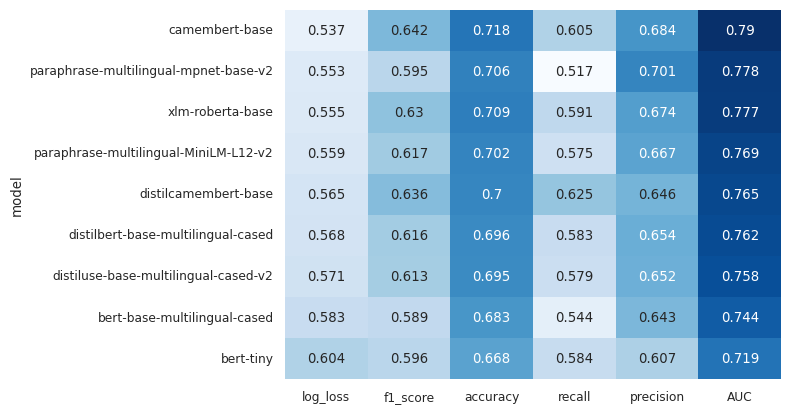

In [34]:
g = sns.heatmap(
    log_df[["log_loss", "f1_score", "accuracy", "recall", "precision", "AUC"]],
    annot=True,
    fmt=".3g",
    cmap="Blues",
    cbar=False,
)

g.figure.savefig(f"{EXP_DIR}/heatmap_metrics.png")

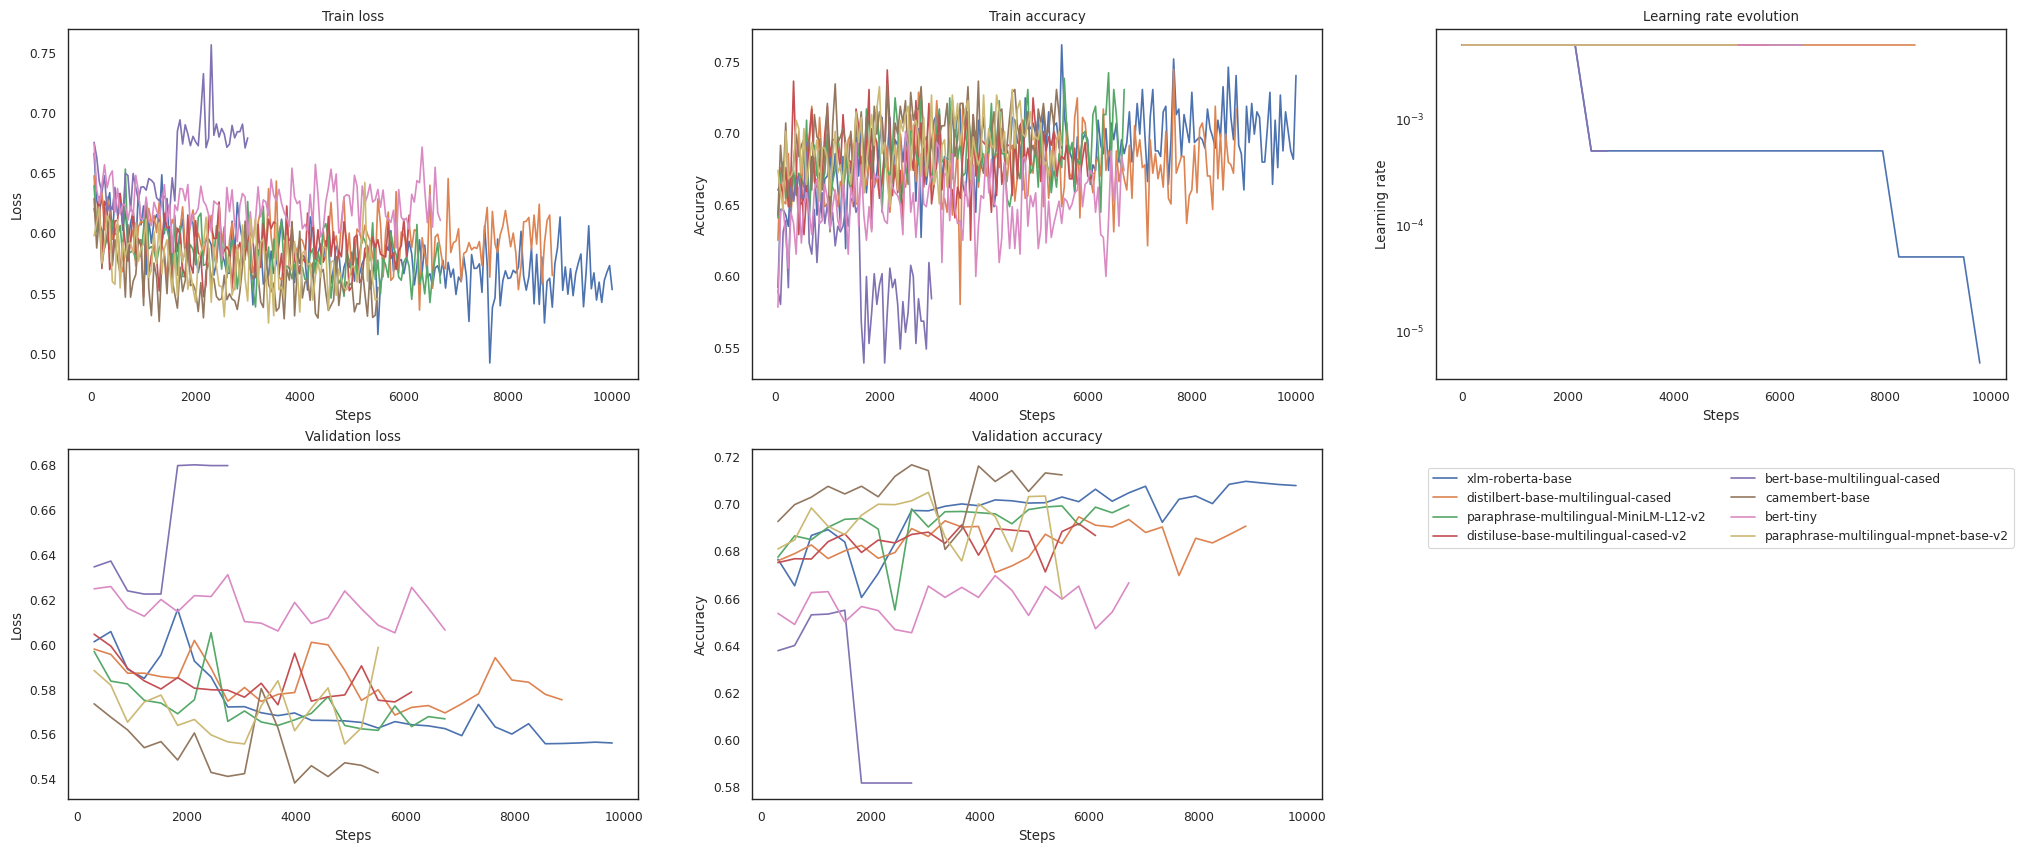

In [38]:
fig, axs = plt.subplots(2, 3, figsize=(25, 10))

colors = sns.color_palette("deep", len(res_dict))
max_step = 10000

for i, model in enumerate(models):
    tmp = res_dict[model]
    try:
        for k in ["train_loss", "val_loss", "train_accuracy", "val_accuracy"]:
            tmp[k] = tmp[k][tmp[k]["step"] < max_step]

        train_steps = tmp["train_loss"]["step"]
        train_loss = tmp["train_loss"]["value"]
        val_steps = tmp["val_loss"]["step"]
        val_loss = tmp["val_loss"]["value"]
        train_acc = tmp["train_accuracy"]["value"]
        val_acc = tmp["val_accuracy"]["value"]
        lr_key = list(tmp.keys())[1]
        lr_steps = tmp[lr_key]["step"]
        lr_val = tmp[lr_key]["value"]

        axs[0, 0].plot(train_steps, train_loss, label=models[model], color=colors[i])
        axs[1, 0].plot(val_steps, val_loss, color=colors[i], linestyle="-")
        axs[0, 0].set(xlabel="Steps", ylabel="Loss", title="Train loss")
        axs[1, 0].set(xlabel="Steps", ylabel="Loss", title="Validation loss")

        axs[0, 1].plot(train_steps, train_acc, label=models[model], color=colors[i])
        axs[1, 1].plot(val_steps, val_acc, color=colors[i], linestyle="-")
        axs[0, 1].set(xlabel="Steps", ylabel="Accuracy", title="Train accuracy")
        axs[1, 1].set(xlabel="Steps", ylabel="Accuracy", title="Validation accuracy")

        axs[0, 2].plot(lr_steps, lr_val, label=models[model], color=colors[i])
        axs[0, 2].set(
            xlabel="Steps", ylabel="Learning rate", title="Learning rate evolution", yscale="log"
        )
        axs[0, 2].legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=2)

        axs[1, 2].axis("off")
    except:
        continue


fig.savefig(f"{EXP_DIR}/loss_evolution.pdf")